# Menu <a class="anchor" id="menu"></a>
* [1 Préparation du jeu de données](#models_prepare)
    * [1.1 Découpage du jeu de données](#models_prepare_split)
    * [1.2 Encodage des variables qualitatives](#models_prepare_encode)
    * [1.3 Imputation des valeurs manquantes](#models_prepare_impute)
    * [1.4 Normalisation](#models_prepare_normalize)
    * [1.5 Choix des outils de mesure](#models_prepare_metrics)
* [2. Algorithmes sans optimisation](#models)
    * [2.1 (Naïve) DummyClassifier](#models_dummy)
    * [2.2 (Linear) Logistic Regression](#models_linear)
    * [2.3 (Non-Linear) Decision Tree](#models_decision_tree)
    * [2.4 (Non-Linear) K-Nearest Neighbors](#models_knn)
    * [2.5 (Ensemble) Random Forest](#models_random_forest)
    * [2.6 (Ensemble) XGBoost](#models_xgboost)
* [3. Recherche des meilleurs paramètres avec `GreadSearchCV`](#models_grid)
    * [3.1 Logistic Regression Grid](#models_linear_grid)
    * [3.2 Decision Tree Grid](#models_decision_tree_grid)
    * [3.3 Random Forest Grid](#models_random_forest_grid)
    * [3.4 XGBoost Grid](#models_xgboost_grid)
* [4. Améliorer les modèles avec `class_weigth`](#models_balanced)
    * [4.1 Logistic Regression](#models_linear_balanced)
    * [4.2 Decision Tree](#models_decision_tree_balanced)
    * [4.3 Random Forest](#models_random_forest_balanced)
    * [4.4 XGBoost Classifier](#models_xgboost_balanced)
* [5. Améliorer les modèles avec `SMOT`](#models_smot)
    * [5.1 Logistic Regression](#models_linear_smot)
    * [5.2 Decision Tree](#models_decision_tree_smot)
    * [5.3 K-Nearest Neighbors](#models_knn_smot)
    * [5.3 Random Forest](#models_random_forest_smot)
    * [5.4 XGBoost Classifier](#models_xgboost_smot)
* [6. Choix des modèles pour la suite](#models_choice)

# Mise en place

### Chargeons les librairies utiles

In [1]:
import time
import copy as cp
from collections import defaultdict
from zipfile import ZipFile

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
#import plotly_express as px


random_seed = 0
np.random.seed(random_seed) # Seed the unexpected randomness of this world

import warnings
warnings.filterwarnings('ignore')

### Chargons le jeu de données

In [2]:
zip_file = ZipFile('data/Projet+Mise+en+prod+-+home-credit-default-risk.zip')

In [3]:
data_application_train = pd.read_csv(
    zip_file.open('application_train.csv'),
    #dtype=dtypes, 
    #usecols=cols_to_keep,
    na_values=["XNA", "Unknown"], 
    true_values=["Y", "Yes", "1"], 
    false_values=["N", "No", "0"]
)

data_application_train.shape

(307511, 122)

### Faisons quelques réglages pour mieux voir les DataFrames pandas

In [4]:
pd.options.display.max_columns = data_application_train.shape[0]
pd.options.display.max_rows = 100

### Supprimons les colonnes que nous savons inutiles

In [5]:
data_application_train.drop(['SK_ID_CURR', 'FLAG_MOBIL', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_4'], axis=1, inplace=True)
data_application_train.shape

(307511, 117)

### Réduisons la taille du jeu de données pour les essais préliminaires des différents modèles

In [6]:
sample_size_base = 30000
sample_size_grid = 30000
data_work = data_application_train[:sample_size_base].copy()

# Préparons le jeu de données <a class="anchor" id="models_prepare"></a> [⇪](#menu)

### Découpage du jeu de données  <a class="anchor" id="models_prepare_split"></a> [⇪](#menu)

> Il existe au moins 2 approches pour le découpage du jeu de données.
> 1. On peut le découper en 3 sous-ensembles `Train`, `Validation` et `Test`.
> 2. On peut le découper en 2 sous-ensembles `Train` et `Test`.
>
> Idéalement, il nous faut idéalement les trois jeux de données:
> - Le `Train` set pour entrainer les différents modèles *(différents algorithmes ou paramètres)*.
> - Le `Validation` set pour choisir le modèle le plus performant sur des données non-vues lors de l'entrainement.
> - Le `Test` set pour estimer la généralisation du modèle choisi *(une fois ré-entrainé avec l'ensemble training+validation)*, et donc vérifier que les scores de validation ne sont pas des overfit ou underfit.
>
> Mais lorsque l'on utiliser une méthode de **cross-validation** comme le K-Fold ou le StratifiedKFold, on peut se contenter d'un découpage en 2 sous jeu de données, car le jeu d'entrainement est alors découper en k sections qui sont tour à tour utilisées en tant que set de `Validation` pour que les k-1 autres sections sont utilisées pour en tant que `Train` set *(ce qui permet d'utiliser une plus grande fraction des données pour l'entrainement final)*.
>
> Dans ce projet, il est utile (et demandé) de faire de la cross-validation, aussi allons nous utiliser un découpage en deux sous ensemble `Train` et `Test`.

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
X_full = data_work.copy()
X_full.drop(['TARGET'], axis=1, inplace=True)

Y_full = data_work['TARGET']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
                                                X_full, 
                                                Y_full, 
                                                test_size=0.15,
                                                random_state=random_seed,
                                                stratify=Y_full)

In [10]:
print(f"X_train: {X_train.shape[0] / X_full.shape[0] * 100}% | X_test: {X_test.shape[0] / X_full.shape[0]* 100}%")

X_train: 85.0% | X_test: 15.0%


### Encodage des données non-numériques <a class="anchor" id="models_prepare_encode"></a> [⇪](#menu)
> Pour pouvoir travailler, les algorithmes ont besoin de données numériques. Il nous faut donc transformer celles qui ne le sont pas avant de pouvoir entrainer et évaluer des modèles.
>
> Il existe plusieurs approches comme le LabelEncoder, l'OrdinalEncoder ou encore le OneHotEncoder.
> - Le `LabelEncoder` est adapté pour transformer la variable cible tout en restant sur une seule colonne.
> - L'`OrdinalEncoder` est adapté pour transformer les features tout en restant sur une seule colonne.
> - Le `OneHotEncoder` est adapté pour transformer les features en valeurs binaires sur plusieurs colonnes.
>
> Pour les variables catégorielles où il n'existe pas de relation ordinale, l'`OrdinalEncoder` peut au mieux ne pas être suffisant, ou au pire induire le modèle en erreur. Dans ce cas, il convient d'utiliser le `OneHotEncoder`.
>
> Les variables qui pourraient être considérée comme ordindal d'après notre EDA sont:
> - `NAME_EDUCATION_TYPE`
> - `WEEKDAY_APPR_PROCESS_START`
>
> Nous allons donc appliquer un `OrdinalEncoder` sur ces deux variables et un `OneHotEncoder` sur le reste. La variable cible elle n'a pas besoin d'être encodée car ce sont déjà des 0 et des 1.

In [11]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder #, LabelEncoder

In [12]:
def fit_labels(data):
    """ Prepare the encoder for the categorical columns.
        
    Parameters
    ----------
    data: pandas' DataFrame
        The dataset used as reference for the label encoders
        
    Returns
    -------
    OrdinalEncoder
        the OE instance used to encode columns with 2 unique values
    OneHotEncoder
        the OHE instance used to encode columns with 3+ unique values
    """
    
    # Define columns
    oe_targets = [x for x in ['NAME_EDUCATION_TYPE', 'WEEKDAY_APPR_PROCESS_START'] if x in data.columns]
    ohe_targets = [x for x in data.select_dtypes(exclude='number').columns if x not in oe_targets]
        
    # OrdinalEncoder
    oe = OrdinalEncoder()
    oe.fit(data[oe_targets])
    
    # OneHotEncoder
    ohe = OneHotEncoder(sparse=False)
    ohe.fit(data[ohe_targets])
    
    return oe, ohe

def transform_labels(data, oe_model, ohe_model):
    """ Transform the provided dataset using the provided encoders.
            
    Parameters
    ----------
    data: pandas' DataFrame
        The dataset that needs to be label encoded
        
    Returns
    -------
    DataFrame
        a new dataframe with the encoded labels instead of the non encoded ones
    """
    dt = data.copy()
    
    # OrdinalEncoder
    dt[oe_model.feature_names_in_] = oe_model.transform(dt[oe_model.feature_names_in_])
    
    # OneHotEncoder
    array_hot_encoded = ohe_model.transform(dt[ohe_model.feature_names_in_])
    data_hot_encoded = pd.DataFrame(array_hot_encoded, index=dt.index, columns=ohe_model.get_feature_names_out())
    data_other_cols = dt.drop(columns=ohe_model.feature_names_in_)
    dt = pd.concat([data_hot_encoded, data_other_cols], axis=1)
    
    return dt

#### On entraine les deux encoders sur le `train` set

In [13]:
oe_model, ohe_model = fit_labels(X_train)

#### On transforme les données des `training` et `testing` sets

In [14]:
X_train = transform_labels(X_train, oe_model, ohe_model)
X_test = transform_labels(X_test, oe_model, ohe_model)

### Imputations des données manquantes <a class="anchor" id="models_prepare_impute"></a> [⇪](#menu)

In [15]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer

In [16]:
def fit_imputer(data, columns):
    
    imputer = SimpleImputer(strategy='median')
    #imputer = IterativeImputer(
    #    imputation_order='ascending', 
    #    random_state=random_seed, 
        #min_value=0, 
        #max_value=max_values_imput
    #    n_nearest_features = 10,
    #)
    imputer.fit(data[columns])
    
    return imputer

def impute(data, imputer):
    
    dt = data.copy()
    dt_imput = pd.DataFrame(imputer.transform(dt[imputer.feature_names_in_]), index=dt.index, columns=imputer.feature_names_in_)
    dt[imputer.feature_names_in_] = dt_imput
    print(dt.shape, type(dt))
    
    return dt

#### On entraine l'imputer sur le `train` set

In [17]:
imputer_model = fit_imputer(X_train, X_train.select_dtypes(include='number').columns)

#### On transforme les données des `training` et `testing` sets

In [18]:
X_train = impute(X_train, imputer_model)
X_test = impute(X_test, imputer_model)

(25500, 233) <class 'pandas.core.frame.DataFrame'>
(4500, 233) <class 'pandas.core.frame.DataFrame'>


#### Regardons le taux de remplissage des colonnes après imputations

<AxesSubplot:>

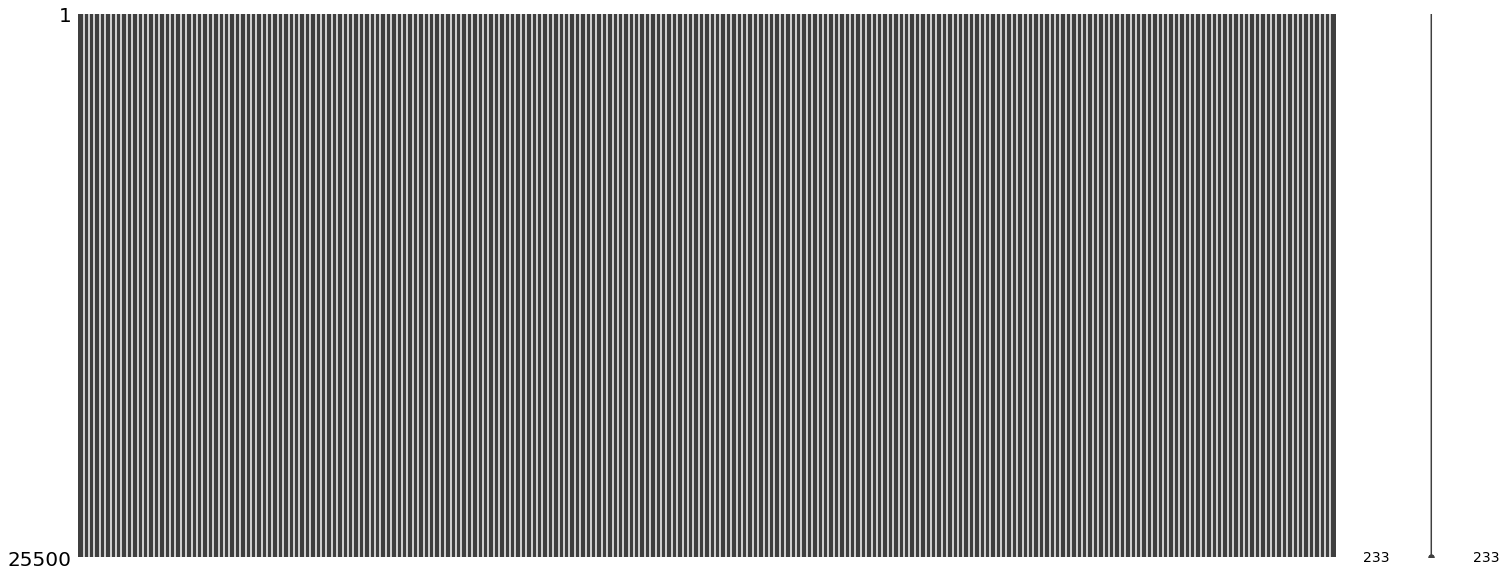

In [19]:
import missingno as msno
msno.matrix(X_train)

### Normalisation du jeu de données <a class="anchor" id="models_prepare_normalize"></a> [⇪](#menu)

> Certains algorithmes de Machine Learning sont sensibles au changement d'échelle des features *(algorithmes basés sur la descente de gradient, algorithmes basés sur la distance)* alors que d'autres *(algorithmes basés sur les arbres...)* y sont pratiquement insensibles.
>
> Comme nous allons essayer plusieurs algorithmes différents, il convient de rendre nos données compatibles avec le plus grand nombre d'algorithmes possibles, donc de toutes les mettre sur une échelle à peu près semblable.
>
> Il existe plusieurs approches pour adapter les données:
> - Le `MinMaxScaler` qui réduit l'intervalle de manière à ce qu'il soit compris entre 0 et 1 *(ou entre -1 et 1 s'il y a des valeurs négatives)*.
> - Le `StandardScaler` qui met à l'échelle les valeurs de sorte que la distribution soit centrée autour de 0, avec un écart-type de 1. *(le `Normalizer` fait la même chose avec les lignes au lieu des colonnes)*.
> - Le `RobustScaler` qui réduit l'intervalle de manière à ce qu'il soit compris entre 0 et 1 *(ou entre -1 et 1 s'il y a des valeurs négatives)* mais en utilisant l'écart interquartile, de sorte qu'il soit plus résistant aux valeurs aberrantes.

In [20]:
from sklearn.preprocessing import MinMaxScaler

In [21]:
def fit_normalizer(data):
       
    scaler = MinMaxScaler()
    scaler.fit(data)
    
    return scaler

def normalize(data, robust_scaler):
    
    dt = data.copy()
    dt = pd.DataFrame(robust_scaler.transform(dt), index=dt.index, columns=dt.columns)
    
    return dt

#### On entraine le scaler sur le `train` set

In [22]:
model_scaler = fit_normalizer(X_train)

#### On transforme les données des `training` et `testing` sets

In [23]:
X_train = normalize(X_train, model_scaler)
X_test = normalize(X_test, model_scaler)

### Définissons quelques fonctions pour faciliter la gestion des scores *(rapports, graphiques, enregistrement)* <a class="anchor" id="models_prepare_metrics"></a> [⇪](#menu)

> Nous devons pour cela choisir nos **outils de mesure**.
>
> L'`accuracy` est souvent utilisé pour des modèles de classification, mais c'est en général insuffissant et il faut faire attention à la `precision` et au `recall`. Optimiser des modèles sur la base de plusieurs mesures différentes n'est pas choses aidée, et il est donc habituellement recommandé d'utiliser le `F1-score` qui calcul la moyenne harmonique entre la `precision` et le `recall`.
>
> Cependant, nous sommes ici dans un cas où **le jeu de données est déséquilibré** en faveur des valeurs négatives *(le client ne fait pas défaut)*, et le `F1-score` n'est pas forcement un bon choix avec un tel jeu de données.
>
> Dans un tel cas, il convient d'utiliser des mesures moins sensibles au déséquilibre des classes.
> - Le `Precision-Recall AUC` score est approprié pour les jeux de données très déséquilibré *(ce qui est le cas ici)*, mais il va donner plus de poids à que la classe positive qu'à la classe négative.
> - Le `ROC AUC` score est approprié pour les jeux de données peu ou modérement déséquilibrés, et il va donner autant d'importance à la classe positive qu'à la classe négative.
>
> Les **True Positives** seront des clients que l'on aura considéré comme non solvable avec raison *(donc on **évite une perte**)*.<br>
> Les **True Negatives** seront des clients que l'on aura considéré comme solvable avec raison *(donc on **gagne de l'argent**)*.<br>
> Les **False Positives** seront des clients que l'on aura considéré comme non solvable à tord *(donc on **loupe de l'argent**)*.<br>
> Les **False Negatives** seront des clients que l'on aura considéré comme solvable à tord *(donc on **perd de l'argent**)*.
>
> Dans notre cas, le plus important est de minimiser les pertes d'argent donc les **FN**, mais il semble au moins aussi important de gagner de l'argent et donc de maximiser les **TN**.
>
> On va donc utiliser le `ROC AUC` comme mesure principale, mais enregistrer les autres pour pouvoir tout de même garder un oeil dessus.


In [24]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, roc_auc_score, roc_curve, classification_report, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, f1_score, average_precision_score

In [25]:
def print_classification_report(y_true, y_pred):
    report = classification_report(y_true, y_pred, labels=[0,1], target_names=['Prediction = 0', 'Prediction = 1'], zero_division=0)
    print("--- Classification Report ---".ljust(100,'-'),"\n\n", report)

In [26]:
def print_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
    fig, ax = plt.subplots(figsize=(6,6))
    disp.plot(ax=ax)
    print("--- Confusion Matrix ---".ljust(100,'-'),"\n")
    plt.show()

In [27]:
def print_rocauc(y_true, y_pred_dict, figsize=[5,5], ax=None, top_others=3):
    
    print(f"--- ROC AUC ---".ljust(100,'-'),"\n")
    auc_scores = {}
    #last_index = len(y_pred_dict)

    if ax == None:
        figure = plt.figure(figsize=figsize)
        ax = plt
        
    # find top scores:
    last_score_name = list(y_pred_dict)[-1]
    sorted_scores = defaultdict(list)
    for i, (model_name, y_pred) in enumerate(y_pred_dict.items()):
        if model_name != last_score_name:
            roc_score = roc_auc_score(y_true, y_pred)
            sorted_scores[model_name] = roc_score
    sorted_scores = sorted(sorted_scores, key=lambda x:sorted_scores[x], reverse=True)[:top_others]
    sorted_scores.append(last_score_name)
    
    # display
    #for i, (model_name, y_pred) in enumerate(y_pred_dict.items()):
    for i, model_name in enumerate(sorted_scores):
        alpha_v = 1 if i == min(top_others, len(sorted_scores)-1) else 0.2
        
        y_pred = y_pred_dict[model_name]
        roc_score = roc_auc_score(y_true, y_pred)
        fpr, tpr, thresholds = roc_curve(y_true, y_pred)
        
        ax.plot(fpr, tpr, label=f"{model_name} ({roc_score:.2f})", alpha=alpha_v)
        auc_scores[model_name] = roc_score
            
    ax.plot([0, 1], [0, 1], label='Random (0.5)', linestyle='--', color='red', alpha=0.5)
    plt.xlabel('FPR (Positive label: 1)')
    plt.ylabel('TPR (Positive label: 1)')
    #plt.legend()
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    plt.show()
    
    return auc_scores

In [28]:
from sklearn.metrics import precision_recall_curve

def print_prauc(y_true, y_pred_dict, figsize=[5,5], ax=None, top_others=3):
    
    print(f"--- PRECISION RECALL AUC ---".ljust(100,'-'), "\n")
    auc_scores = {}
    #last_index = len(y_pred_dict)

    if ax == None:
        figure = plt.figure(figsize=figsize)
        ax = plt
        
    # find top scores:
    last_score_name = list(y_pred_dict)[-1]
    sorted_scores = defaultdict(list)
    for i, (model_name, y_pred) in enumerate(y_pred_dict.items()):
        if model_name != last_score_name:
            pr_score = average_precision_score(y_true, y_pred)
            sorted_scores[model_name] = pr_score
    sorted_scores = sorted(sorted_scores, key=lambda x:sorted_scores[x], reverse=True)[:top_others]
    sorted_scores.append(last_score_name)

    # display
    #for i, (model_name, y_pred) in enumerate(y_pred_dict.items()):
    for i, model_name in enumerate(sorted_scores):
        alpha_v = 1 if i == min(top_others, len(sorted_scores)-1) else 0.2
        
        y_pred = y_pred_dict[model_name]
        pr_score = average_precision_score(y_true, y_pred)
        precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
        
        ax.plot(recall, precision, label=f"{model_name} ({pr_score:.2f})", alpha=alpha_v)
        auc_scores[model_name] = pr_score
        
    no_skill = len(y_true[y_true==1]) / len(y_true)            
    ax.plot([0, 1], [no_skill, no_skill], label='No skill', linestyle='--', color='red', alpha=0.3)
    ax.plot([1, 0], [0, 1], label='Balanced', linestyle='--', color='green', alpha=0.5)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    #plt.legend()
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
    plt.show()
    
    return auc_scores

In [29]:
def save_score(method_name, threshold, param_grid, training_time, inference_time, **scores):
    
    idx = np.where(scores_df.Method == method_name)[0]        
    idx = idx[0] if idx.size > 0 else len(scores_df.index)
    
    rocauc_value = scores.get('roc_auc', None)
    f1_value =  scores.get('f1', None)
    accuracy_value =  scores.get('accuracy', None)
    precision_value =  scores.get('precision', None)
    recall_value = scores.get('recall', None)
    prauc_value = scores.get('average_precision', None)
    TP = scores.get('TP', None)
    FP = scores.get('FP', None)
    TN = scores.get('TN', None)
    FN = scores.get('FN', None)
    
    scores_df.loc[idx] = [method_name, threshold, param_grid, rocauc_value, prauc_value, f1_value, accuracy_value, precision_value, recall_value, TP, TN, FP, FN, training_time, inference_time]    
    scores_df.to_csv(scores_path, index=False)

In [30]:
scores_df = pd.DataFrame(columns=['Method', 'threshold', 'params', 'ROC AUC', 'PR AUC', 'F1 score', 'Accuracy', 'Precision', 'Recall', 'TP', 'TN', 'FP', 'FN', 'Training time', 'Inference time'])
y_preds = {}
scores_path = 'data/scores.csv'
scores_df.to_csv(scores_path, index=False)

def get_scores(method_name, model, X_ref=None, y_ref=None, param_grid=None, threshold=None, training_time=None, inference_time=None, register=False, simple=False, show_classification=True, show_confusion=True, show_roccurves=True, **scores):
    
    if X_ref is None:
        X_ref = X_test
        
    if y_ref is None:
        y_ref = y_test
    
    y_pred, y_pred_proba, inference_time = predict(model, X_ref, threshold)
    cm = confusion_matrix(y_ref, y_pred, labels=[0,1])

    scores = {
        'roc_auc': roc_auc_score(y_ref, y_pred_proba),
        'f1': f1_score(y_ref, y_pred),
        'accuracy': accuracy_score(y_ref, y_pred),
        'precision': precision_score(y_ref, y_pred, zero_division=0),
        'recall': recall_score(y_ref, y_pred),
        'average_precision': average_precision_score(y_ref, y_pred_proba),
        'TN': cm[0][0],
        'FP': cm[0][1],
        'FN': cm[1][0],
        'TP': cm[1][1],
    }
    
    # Register score and replace if it already exists
    if register:
        save_score(method_name, threshold, param_grid, training_time, inference_time, **scores)
    
    # Basic report
    scores_str = ""
    for key in scores.keys():
        if type(scores[key]) == np.float64 and key not in ['TP','TN','FP','FN']:
            scores_str += f"{key.upper().rjust(20)} : {scores[key]:.4f}\n"
            
    print('-'*100,f'These information are based on the best estimator of the above cross-validation'.center(100,), '-'*100, sep='\n', end='\n\n')
    print(f"--- {method_name} ---".ljust(100,'-'),"\n\n",scores_str, sep="")
          
    if simple:
        return
    
    # Classification report
    if show_classification:
        print_classification_report(y_ref, y_pred)
    
    # Confusion Matrix
    if show_confusion:
        print_confusion_matrix(y_ref, y_pred)
    
    # ROC AUC curves
    if show_roccurves:
        y_preds[method_name] = y_pred_proba
        print_rocauc(y_ref, y_preds)
        print_prauc(y_ref, y_preds)

In [31]:
def predict(model, X_ref, threshold=None):
    t0 = time.perf_counter()
    
    y_pred_proba = model.predict_proba(X_ref)[:,1]
    if threshold:
        y_pred = get_labels_from_threshold(y_pred_proba, threshold)
    else:
        y_pred = model.predict(X_ref)
    
    tt = time.perf_counter() - t0
    return y_pred, y_pred_proba, tt

In [32]:
def get_labels_from_threshold(y_proba, threshold):
    return (y_proba >= threshold).astype('int')

def find_best_threshold(model, X_valid, y_valid, eval_function ):

    best_threshold = 0.0
    best_score = 0.0
    y_pred_proba = model.predict_proba(X_valid)[:,1]
    
    for threshold in np.arange(0, 1, 0.001):
        
        y_pred_threshold = get_labels_from_threshold(y_pred_proba, threshold)
        
        score = eval_function(y_valid, y_pred_threshold)
        if score >= best_threshold:
            best_threshold = threshold
            best_score = score
        
    return best_score, best_threshold

In [33]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV, HalvingRandomSearchCV  # --> ne supporte pas le multi-scoring
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV # --> GridSearchCV trop lent


def fit_model(model_name, model, X_ref=None, y_ref=None, param_grid = {}, scoring='roc_auc', cv=5, verbose=2, register=True):
    
    if X_ref is None:
        X_ref = X_train
        
    if y_ref is None:
        y_ref = y_train
        
    fit_time = time.perf_counter()
    grid_model = RandomizedSearchCV(model, param_grid, scoring=scoring, n_jobs=-1, verbose=0, cv=cv, random_state=random_seed, refit=scoring)
    #grid_model = HalvingRandomSearchCV(model, param_grid, scoring=scoring, n_jobs=-1, verbose=0, cv=cv, min_resources=500, random_state=random_seed)
    #grid_model = HalvingGridSearchCV(model, param_grid, scoring=scoring, n_jobs=-1, verbose=0, cv=cv, min_resources=500, random_state=random_seed)
    #grid_model = GridSearchCV(model, param_grid, scoring=scoring, n_jobs=-1, verbose=0, cv=cv, refit="roc_auc", return_train_score=True)
    grid_model.fit(X_ref, y_ref)
    fit_time = time.perf_counter() - fit_time

    results = grid_model.cv_results_
    n_splits = cv.n_splits if hasattr(cv, 'n_splits') else cv
    sets_list = ["test"] if verbose < 3 else ["train", "test"]
    
    # Print K-fold scores
    if verbose > 1:
        for i in range(n_splits):
            print(f"".center(100,'-'))
        
            for sample in sets_list:
                scores_str = f"{scoring.upper()}: {results[f'split{i}_{sample}_score'].mean():.4f}"
                print(f"FOLD-{i+1} {sample.upper().rjust(6)} scores | {scores_str}")
                
    # Print overall scores
    if verbose > 0:
   
        for sample in sets_list:
            print('\n', f" {sample.upper()}-CV-SPLIT MEAN SCORES ".center(100,'-'), sep='')
            mean_str = f"{scoring.upper()}: {results[f'mean_{sample}_score'].mean():.4f} (std:{results[f'std_{sample}_score'].mean():.4f})"
            print(f"\n- {mean_str}")
            
        print("\n", f"".center(100,'-'), sep='')
    
    inf_time = pd.Series(grid_model.cv_results_['mean_score_time']).mean()
    
    return {'grid':grid_model, 'model':grid_model.best_estimator_, 'training_time':fit_time, 'inference_time':inf_time, 'param_grid':param_grid} #, **scores_args}

In [34]:
def get_model_name(model):
    index = str(model).index('(')
    return str(model)[:index]

#### Let's define the cross-validation method

In [35]:
from sklearn.model_selection import StratifiedKFold

skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_seed)

In [36]:
import FreeMobileSMS as sms
sms.send("Data preparation done", stop=False)

# Essayons quelques algorithmes sans optimisation <a class="anchor" id="models"></a> [⇪](#menu)

## 1. Établissons une base-line avec un algorithm naïf *(Dummy Classifier)* <a class="anchor" id="models_dummy"></a> [⇪](#menu)

In [37]:
from sklearn.dummy import DummyClassifier

In [38]:
model_name = "DummyClassifier"

In [39]:
grd_dummy = fit_model( 
    model_name,
    DummyClassifier(),
    param_grid={ 'random_state':[random_seed], 'strategy':['stratified'] }, 
    cv = skfold,
    verbose=2,
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | ROC_AUC: 0.4985
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | ROC_AUC: 0.4931
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | ROC_AUC: 0.5038
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | ROC_AUC: 0.4986
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | ROC_AUC: 0.4959

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- ROC_AUC: 0.4980 (std:0.0035)

----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- DummyClassifier --------------------------------------------------------------------------------

             ROC_AUC : 0.4905
                  F1 : 0.0666
            ACCURACY : 0.8442
           PRECISION : 0.0639
              RECALL : 0.0694
   AVERAGE_PRECISION : 0.0789

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.92      0.91      0.92      4140
Prediction = 1       0.06      0.07      0.07       360

      accuracy                           0.84      4500
     macro avg       0.49      0.49      0.49      4500
  weighted avg       0.85  

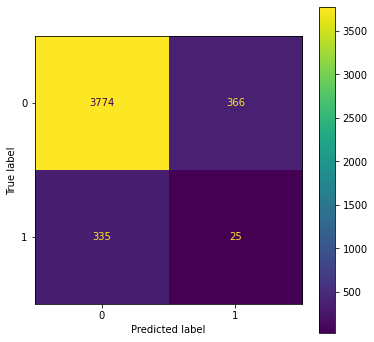

--- ROC AUC ---------------------------------------------------------------------------------------- 



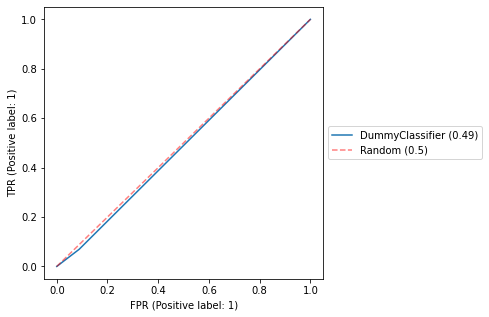

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



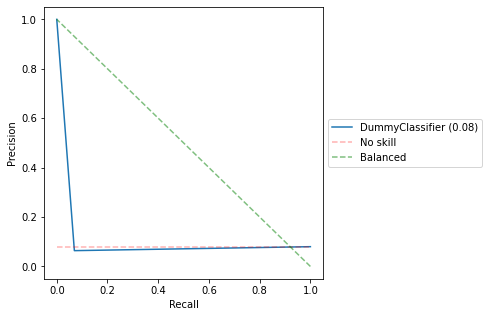

In [40]:
get_scores(model_name, **grd_dummy, register=True)

In [41]:
del grd_dummy

## 2. Essayons un algorithme linéaire - Logistic Regression <a class="anchor" id="models_linear"></a> [⇪](#menu)

In [38]:
from sklearn.linear_model import LogisticRegression

In [43]:
model_name = "Basic LogisticRegression"
max_lr_iter = 3000

grd_log = fit_model(
    model_name,
    LogisticRegression(), 
    param_grid={ 'random_state':[random_seed], 'max_iter':[max_lr_iter] },  
    cv = skfold,
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | ROC_AUC: 0.7315
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | ROC_AUC: 0.7457
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | ROC_AUC: 0.7338
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | ROC_AUC: 0.7242
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | ROC_AUC: 0.7259

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- ROC_AUC: 0.7322 (std:0.0076)

----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Basic LogisticRegression -----------------------------------------------------------------------

             ROC_AUC : 0.7325
                  F1 : 0.0000
            ACCURACY : 0.9189
           PRECISION : 0.0000
              RECALL : 0.0000
   AVERAGE_PRECISION : 0.2003

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.92      1.00      0.96      4140
Prediction = 1       0.00      0.00      0.00       360

      accuracy                           0.92      4500
     macro avg       0.46      0.50      0.48      4500
  weighted avg       0.85  

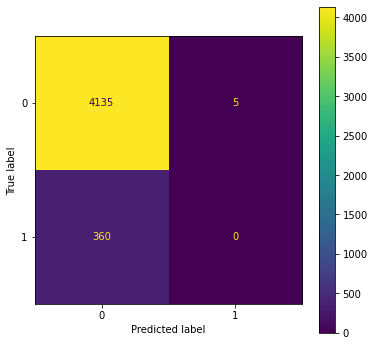

--- ROC AUC ---------------------------------------------------------------------------------------- 



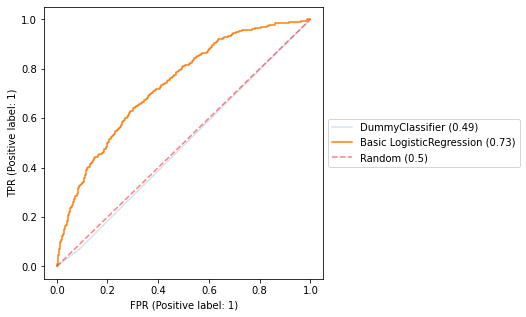

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



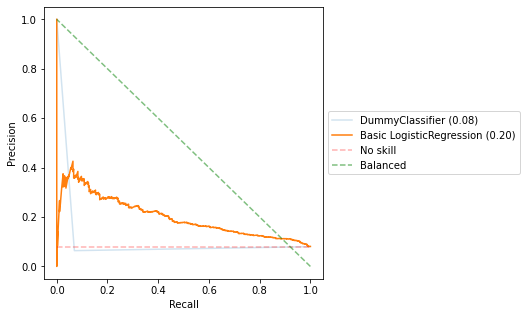

In [44]:
get_scores(model_name, **grd_log, register=True)

#### Let's find the best threshold *(based on F1 score)*

In [45]:
f1_value, best_threshold = find_best_threshold(grd_log['model'], X_train, y_train, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.24225526641883519) for this model is reached with a threshold of 0.243


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Basic LogisticRegression [w/thresholding] ------------------------------------------------------

             ROC_AUC : 0.7325
                  F1 : 0.2103
            ACCURACY : 0.9016
           PRECISION : 0.2935
              RECALL : 0.1639
   AVERAGE_PRECISION : 0.2003

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.93      0.97      0.95      4140
Prediction = 1       0.29      0.16      0.21       360

      accuracy                           0.90      4500
     macro avg       0.61      0.56      0.58      4500
  weighted avg       0.88  

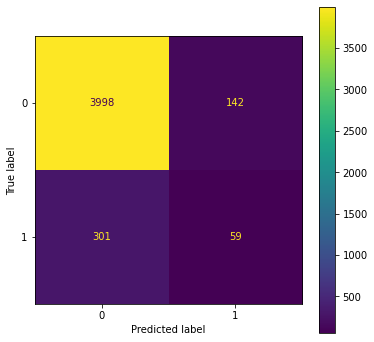

In [46]:
get_scores(f"{model_name} [w/thresholding]", **grd_log, threshold=best_threshold, register=True, show_roccurves=False)

In [47]:
del grd_log

## 3. Essayons un algorithme non-linéaire - Decision Tree <a class="anchor" id="models_decision_tree"></a> [⇪](#menu)

In [39]:
from sklearn.tree import DecisionTreeClassifier

In [49]:
model_name = "Basic DecisionTreeClassifier"

grd_dt = fit_model(
    model_name,
    DecisionTreeClassifier(), 
    param_grid={ 'random_state':[random_seed] }, 
    cv = skfold
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | ROC_AUC: 0.5309
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | ROC_AUC: 0.5351
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | ROC_AUC: 0.5292
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | ROC_AUC: 0.5301
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | ROC_AUC: 0.5241

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- ROC_AUC: 0.5299 (std:0.0035)

----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Basic DecisionTreeClassifier -------------------------------------------------------------------

             ROC_AUC : 0.5315
                  F1 : 0.1391
            ACCURACY : 0.8542
           PRECISION : 0.1318
              RECALL : 0.1472
   AVERAGE_PRECISION : 0.0876

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.93      0.92      0.92      4140
Prediction = 1       0.13      0.15      0.14       360

      accuracy                           0.85      4500
     macro avg       0.53      0.53      0.53      4500
  weighted avg       0.86  

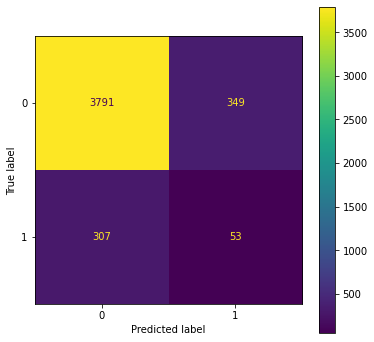

--- ROC AUC ---------------------------------------------------------------------------------------- 



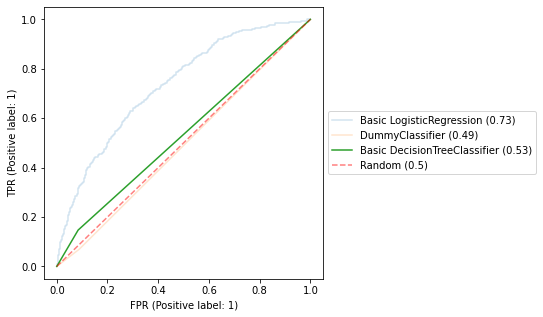

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



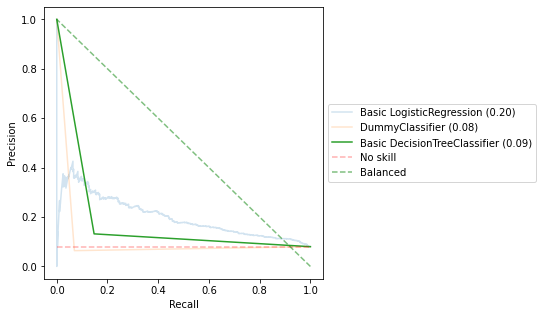

In [50]:
get_scores(model_name, **grd_dt, register=True)

#### Trouvons le meilleur seuil de séparation pour les prédiction *(sur la base du F1 score)*

In [51]:
f1_value, best_threshold = find_best_threshold(grd_dt['model'], X_train, y_train, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (1.0) for this model is reached with a threshold of 0.999


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Basic DecisionTreeClassifier [w/thresholding] --------------------------------------------------

             ROC_AUC : 0.5315
                  F1 : 0.1391
            ACCURACY : 0.8542
           PRECISION : 0.1318
              RECALL : 0.1472
   AVERAGE_PRECISION : 0.0876

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.93      0.92      0.92      4140
Prediction = 1       0.13      0.15      0.14       360

      accuracy                           0.85      4500
     macro avg       0.53      0.53      0.53      4500
  weighted avg       0.86  

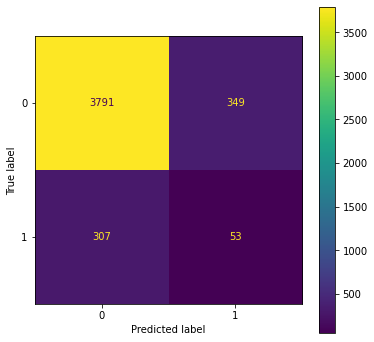

In [52]:
get_scores(f"{model_name} [w/thresholding]", **grd_dt, threshold=best_threshold, register=True, show_roccurves=False)

In [53]:
del grd_dt

## 4. Essayons un autre algorithme non-linéaire - KNN *(k-nearest neighbors)* <a class="anchor" id="models_knn"></a> [⇪](#menu)

In [40]:
from sklearn.neighbors import KNeighborsClassifier

In [55]:
model_name = "Basic KNeighborsClassifier"

grd_knn = fit_model(
    model_name,
    KNeighborsClassifier(n_jobs=-1), 
    param_grid={},  
    cv = skfold,
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | ROC_AUC: 0.5346
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | ROC_AUC: 0.5381
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | ROC_AUC: 0.5474
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | ROC_AUC: 0.5420
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | ROC_AUC: 0.5419

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- ROC_AUC: 0.5408 (std:0.0043)

----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Basic KNeighborsClassifier ---------------------------------------------------------------------

             ROC_AUC : 0.5436
                  F1 : 0.0052
            ACCURACY : 0.9147
           PRECISION : 0.0385
              RECALL : 0.0028
   AVERAGE_PRECISION : 0.0895

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.92      0.99      0.96      4140
Prediction = 1       0.04      0.00      0.01       360

      accuracy                           0.91      4500
     macro avg       0.48      0.50      0.48      4500
  weighted avg       0.85  

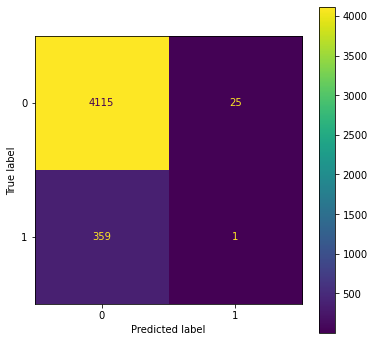

--- ROC AUC ---------------------------------------------------------------------------------------- 



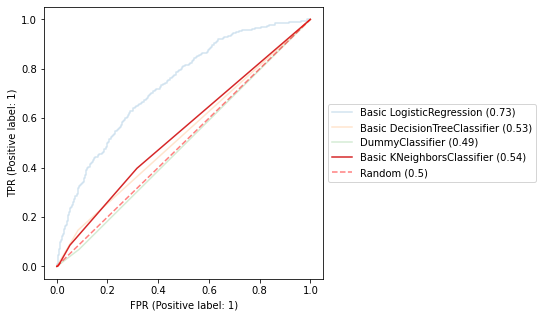

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



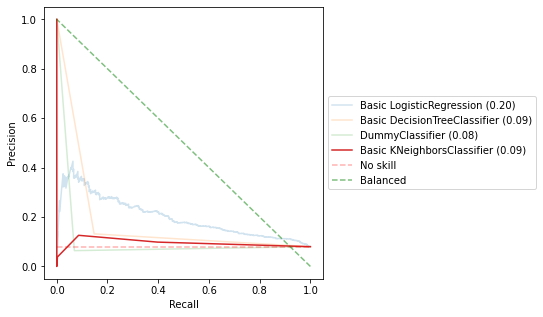

In [56]:
get_scores(model_name, **grd_knn, register=True)

#### Trouvons le meilleur seuil de séparation pour les prédiction *(sur la base du F1 score)*

In [57]:
f1_value, best_threshold = find_best_threshold(grd_knn['model'], X_train, y_train, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.3839491916859123) for this model is reached with a threshold of 0.384


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Basic KNeighborsClassifier [w/thresholding] ----------------------------------------------------

             ROC_AUC : 0.5436
                  F1 : 0.1023
            ACCURACY : 0.8791
           PRECISION : 0.1260
              RECALL : 0.0861
   AVERAGE_PRECISION : 0.0895

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.92      0.95      0.94      4140
Prediction = 1       0.13      0.09      0.10       360

      accuracy                           0.88      4500
     macro avg       0.52      0.52      0.52      4500
  weighted avg       0.86  

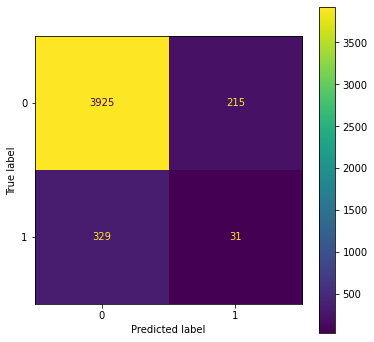

In [58]:
get_scores(f"{model_name} [w/thresholding]", **grd_knn, threshold=best_threshold, register=True, show_roccurves=False)

In [59]:
del grd_knn

## 5. Essayons un autre algorithme non-linéaire - SVM *(Support Vector Machine)* <a class="anchor" id="models_svm"></a> [⇪](#menu)

In [41]:
from sklearn.svm import SVC

In [61]:
model_name = "Basic SupportVectorClassifier"

grd_svm = fit_model(
    model_name,
    SVC(probability=True), 
    param_grid={'random_state':[random_seed]},
    cv = skfold,
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | ROC_AUC: 0.6364
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | ROC_AUC: 0.6234
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | ROC_AUC: 0.6498
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | ROC_AUC: 0.6489
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | ROC_AUC: 0.6321

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- ROC_AUC: 0.6381 (std:0.0101)

----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Basic SupportVectorClassifier ------------------------------------------------------------------

             ROC_AUC : 0.6433
                  F1 : 0.0000
            ACCURACY : 0.9200
           PRECISION : 0.0000
              RECALL : 0.0000
   AVERAGE_PRECISION : 0.1275

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.92      1.00      0.96      4140
Prediction = 1       0.00      0.00      0.00       360

      accuracy                           0.92      4500
     macro avg       0.46      0.50      0.48      4500
  weighted avg       0.85  

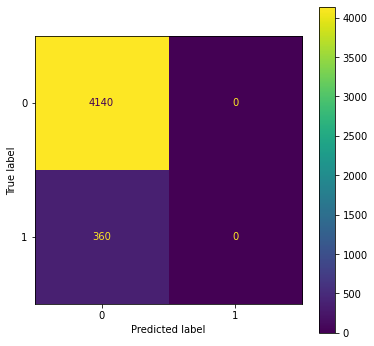

--- ROC AUC ---------------------------------------------------------------------------------------- 



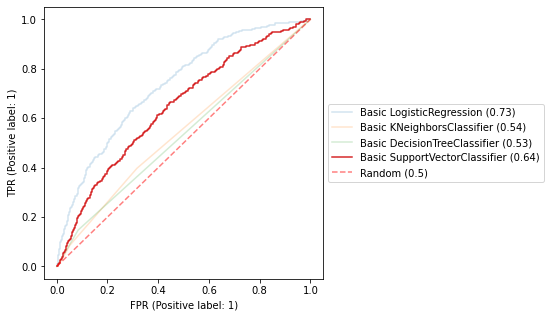

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



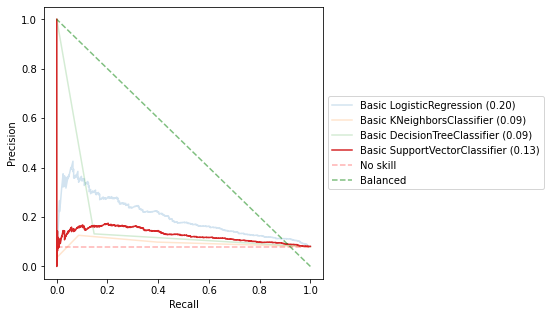

In [62]:
get_scores(model_name, **grd_svm, register=True)

#### Trouvons le meilleur seuil de séparation pour les prédiction *(sur la base du F1 score)*

In [63]:
f1_value, best_threshold = find_best_threshold(grd_svm['model'], X_train, y_train, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.2932330827067669) for this model is reached with a threshold of 0.292


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Basic SupportVectorClassifier [w/thresholding] -------------------------------------------------

             ROC_AUC : 0.6433
                  F1 : 0.0000
            ACCURACY : 0.9191
           PRECISION : 0.0000
              RECALL : 0.0000
   AVERAGE_PRECISION : 0.1275

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.92      1.00      0.96      4140
Prediction = 1       0.00      0.00      0.00       360

      accuracy                           0.92      4500
     macro avg       0.46      0.50      0.48      4500
  weighted avg       0.85  

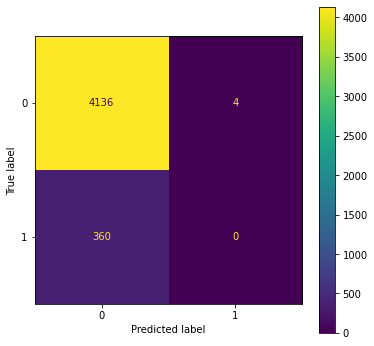

In [64]:
get_scores(f"{model_name} [w/thresholding]", **grd_svm, threshold=best_threshold, register=True, show_roccurves=False)

In [65]:
del grd_svm

## 5. Essayons un algorithme d'ensemble - Random Forest <a class="anchor" id="models_random_forest"></a> [⇪](#menu)

In [42]:
from sklearn.ensemble import RandomForestClassifier

In [67]:
model_name = "Basic RandomForestClassifier"

grd_rf = fit_model(
    model_name,
    RandomForestClassifier(n_jobs=-1), 
    param_grid={ 'random_state':[random_seed] }, 
    cv = skfold
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | ROC_AUC: 0.7055
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | ROC_AUC: 0.7222
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | ROC_AUC: 0.6863
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | ROC_AUC: 0.6916
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | ROC_AUC: 0.6861

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- ROC_AUC: 0.6984 (std:0.0138)

----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Basic RandomForestClassifier -------------------------------------------------------------------

             ROC_AUC : 0.6947
                  F1 : 0.0000
            ACCURACY : 0.9200
           PRECISION : 0.0000
              RECALL : 0.0000
   AVERAGE_PRECISION : 0.1635

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.92      1.00      0.96      4140
Prediction = 1       0.00      0.00      0.00       360

      accuracy                           0.92      4500
     macro avg       0.46      0.50      0.48      4500
  weighted avg       0.85  

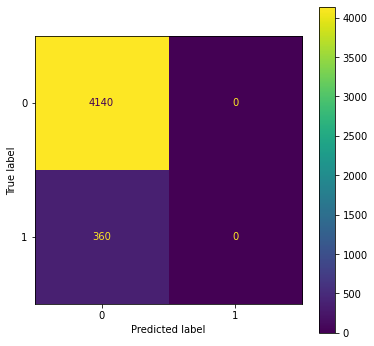

--- ROC AUC ---------------------------------------------------------------------------------------- 



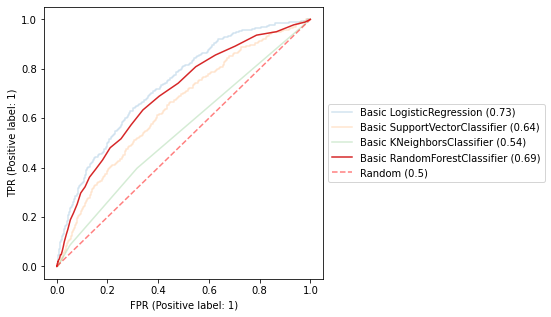

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



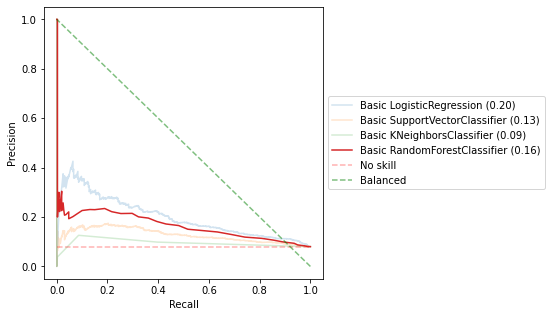

In [68]:
get_scores(model_name, **grd_rf, register=True)

#### Trouvons le meilleur seuil de séparation pour les prédiction *(sur la base du F1 score)*

In [69]:
f1_value, best_threshold = find_best_threshold(grd_rf['model'], X_train, y_train, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.7126654064272211) for this model is reached with a threshold of 0.68


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Basic RandomForestClassifier [w/thresholding] --------------------------------------------------

             ROC_AUC : 0.6947
                  F1 : 0.0000
            ACCURACY : 0.9200
           PRECISION : 0.0000
              RECALL : 0.0000
   AVERAGE_PRECISION : 0.1635

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.92      1.00      0.96      4140
Prediction = 1       0.00      0.00      0.00       360

      accuracy                           0.92      4500
     macro avg       0.46      0.50      0.48      4500
  weighted avg       0.85  

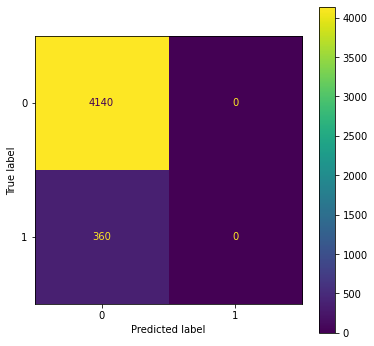

In [70]:
get_scores(f"{model_name} [w/thresholding]", **grd_rf, threshold=best_threshold, register=True, show_roccurves=False)

In [71]:
del grd_rf

## 6. Essayons un autre algorithme d'ensemble - XGBoost Classifier <a class="anchor" id="models_xgboost"></a> [⇪](#menu)

In [43]:
from xgboost import XGBClassifier

In [73]:
model_name = "Basic XGBClassifier"

param_grid = {
    'seed':[random_seed],
    'objective':['binary:logistic'], # classification
    'eval_metric':['auc'], # classification
    'nthread':[-1],
}

grd_xgb = fit_model(
    model_name,
    XGBClassifier(verbosity=1),
    param_grid=param_grid,
    cv = skfold
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | ROC_AUC: 0.7012
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | ROC_AUC: 0.7243
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | ROC_AUC: 0.7120
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | ROC_AUC: 0.7003
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | ROC_AUC: 0.6993

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- ROC_AUC: 0.7074 (std:0.0096)

----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Basic XGBClassifier ----------------------------------------------------------------------------

             ROC_AUC : 0.7058
                  F1 : 0.0782
            ACCURACY : 0.9162
           PRECISION : 0.3265
              RECALL : 0.0444
   AVERAGE_PRECISION : 0.1906

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.92      0.99      0.96      4140
Prediction = 1       0.33      0.04      0.08       360

      accuracy                           0.92      4500
     macro avg       0.62      0.52      0.52      4500
  weighted avg       0.88  

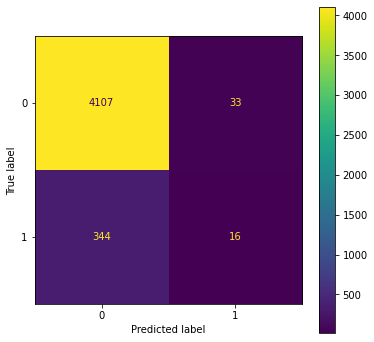

--- ROC AUC ---------------------------------------------------------------------------------------- 



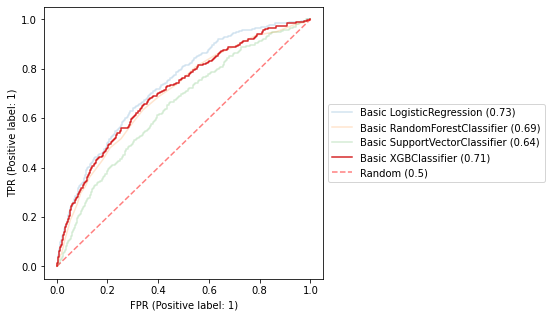

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



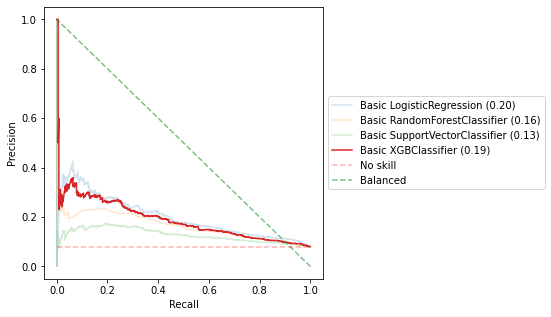

In [74]:
get_scores(model_name, **grd_xgb, register=True)

#### Trouvons le meilleur seuil de séparation pour les prédiction *(sur la base du F1 score)*

In [75]:
f1_value, best_threshold = find_best_threshold(grd_xgb['model'], X_train, y_train, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.5556733828207847) for this model is reached with a threshold of 0.555


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Basic XGBClassifier [w/thresholding] -----------------------------------------------------------

             ROC_AUC : 0.7058
                  F1 : 0.0360
            ACCURACY : 0.9167
           PRECISION : 0.2414
              RECALL : 0.0194
   AVERAGE_PRECISION : 0.1906

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.92      0.99      0.96      4140
Prediction = 1       0.24      0.02      0.04       360

      accuracy                           0.92      4500
     macro avg       0.58      0.51      0.50      4500
  weighted avg       0.87  

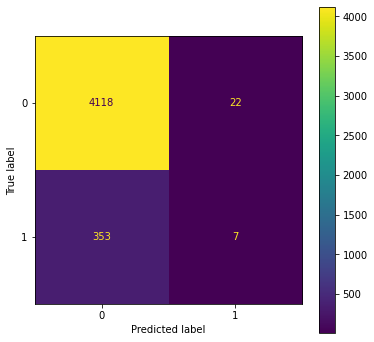

In [76]:
get_scores(f"{model_name} [w/thresholding]", **grd_xgb, threshold=best_threshold, register=True, show_roccurves=False)

In [77]:
del grd_xgb

del grd_## 7. Revue des scores <a class="anchor" id="models_scores"></a> [⇪](#menu)

In [78]:
scores_df[ ~(scores_df.Method.str.contains('threshold')) & (scores_df.Method.str.contains('Basic')) ][['Method','ROC AUC', 'F1 score','Recall']]

,Method,ROC AUC,F1 score,Recall
1,Basic LogisticRegression,0.732543,0.000000,0.000000
3,Basic DecisionTreeClassifier,0.531461,0.139108,0.147222
5,Basic KNeighborsClassifier,0.543629,0.005181,0.002778
7,Basic SupportVectorClassifier,0.643330,0.000000,0.000000
9,Basic RandomForestClassifier,0.694727,0.000000,0.000000
11,Basic XGBClassifier,0.705847,0.078240,0.044444


In [79]:
scores_df[ (scores_df.Method.str.contains('threshold')) & (scores_df.Method.str.contains('Basic')) ][['Method','ROC AUC', 'F1 score','Recall']]

,Method,ROC AUC,F1 score,Recall
2,Basic LogisticRegression [w/thresholding],0.732543,0.210339,0.163889
4,Basic DecisionTreeClassifier [w/thresholding],0.531461,0.139108,0.147222
6,Basic KNeighborsClassifier [w/thresholding],0.543629,0.102310,0.086111
8,Basic SupportVectorClassifier [w/thresholding],0.643330,0.000000,0.000000
10,Basic RandomForestClassifier [w/thresholding],0.694727,0.000000,0.000000
12,Basic XGBClassifier [w/thresholding],0.705847,0.035990,0.019444


In [80]:
sms.send("Basic done", stop=False)

# Recherche des meilleurs paramètres avec GreadSearchCV <a class="anchor" id="models_grid"></a> [⇪](#menu)

## 1. Logistic Regression Grid<a class="anchor" id="models_linear_grid"></a> [⇪](#menu)

In [81]:
from scipy.stats import uniform, loguniform

In [82]:
param_grid = [
    {
        'random_state':[random_seed],
        'max_iter':[max_lr_iter],
        'solver' : ['lbfgs'],
        'penalty' : ['l2'], # none
        'C' : loguniform(1e-5, 1e2),
    },
    {
        'random_state':[random_seed],
        'max_iter':[max_lr_iter],
        'solver' : ['liblinear'],
        'penalty' : ['l1', 'l2'], # none
        'C' : loguniform(1e-5, 1e2),
    },
    {
        'random_state':[random_seed],
        'max_iter':[max_lr_iter],
        'solver' : ['saga'],
        'penalty' : ['elasticnet'], # none
        'C' : loguniform(1e-5, 1e2),
        'l1_ratio' : uniform(0,1)
    },
]

In [83]:
model_name = "Grid LogisticRegression"

grd_log = fit_model(
    model_name,
    LogisticRegression(), 
    param_grid=param_grid,  
    cv = skfold
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | ROC_AUC: 0.6951
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | ROC_AUC: 0.7101
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | ROC_AUC: 0.6953
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | ROC_AUC: 0.6940
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | ROC_AUC: 0.6900

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- ROC_AUC: 0.6969 (std:0.0078)

----------------------------------------------------------------------------------------------------


In [84]:
grd_log['grid'].best_params_

{'C': 0.2317105870400502,
 'max_iter': 3000,
 'penalty': 'l1',
 'random_state': 0,
 'solver': 'liblinear'}

----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Grid LogisticRegression ------------------------------------------------------------------------

             ROC_AUC : 0.7333
                  F1 : 0.0055
            ACCURACY : 0.9196
           PRECISION : 0.2500
              RECALL : 0.0028
   AVERAGE_PRECISION : 0.2074

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.92      1.00      0.96      4140
Prediction = 1       0.25      0.00      0.01       360

      accuracy                           0.92      4500
     macro avg       0.59      0.50      0.48      4500
  weighted avg       0.87  

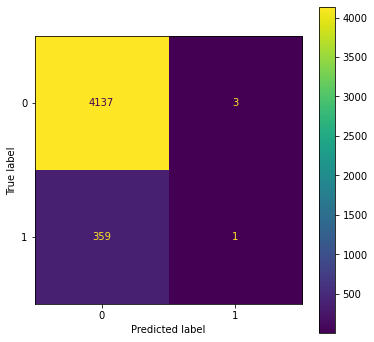

--- ROC AUC ---------------------------------------------------------------------------------------- 



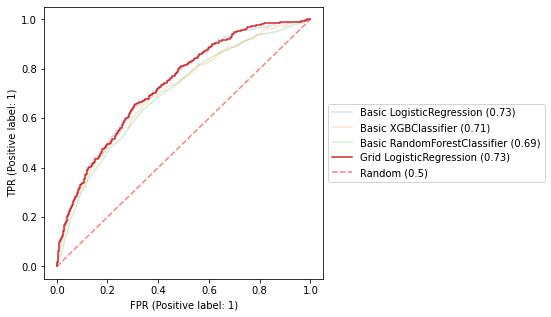

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



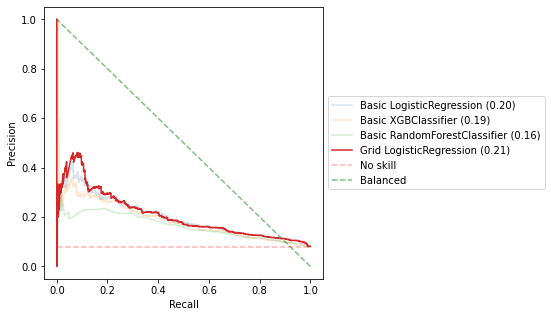

In [85]:
get_scores(model_name, **grd_log, register=True)

#### Trouvons le meilleur seuil de séparation pour les prédiction *(sur la base du F1 score)*

In [86]:
f1_value, best_threshold = find_best_threshold(grd_log['model'], X_train, y_train, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.23223039215686278) for this model is reached with a threshold of 0.232


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Grid LogisticRegression [w/thresholding] -------------------------------------------------------

             ROC_AUC : 0.7333
                  F1 : 0.2207
            ACCURACY : 0.9011
           PRECISION : 0.2986
              RECALL : 0.1750
   AVERAGE_PRECISION : 0.2074

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.93      0.96      0.95      4140
Prediction = 1       0.30      0.17      0.22       360

      accuracy                           0.90      4500
     macro avg       0.61      0.57      0.58      4500
  weighted avg       0.88  

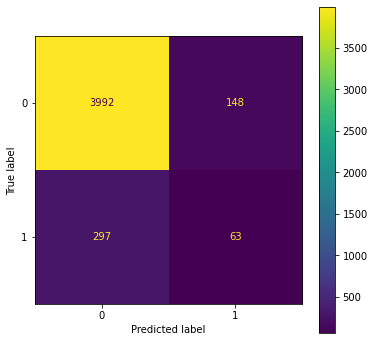

In [87]:
get_scores(f"{model_name} [w/thresholding]", **grd_log, threshold=best_threshold, register=True, show_roccurves=False)

In [88]:
del grd_log

## 2. Decision Tree Grid <a class="anchor" id="models_decision_tree_grid"></a> [⇪](#menu)

In [89]:
param_grid = {
    'random_state':[random_seed],
    'criterion' :['gini', 'entropy'],
    'splitter' : ["best", "random"],
    'max_depth' : [None, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    #'min_samples_split' : [None, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    'min_samples_leaf' : [None, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    'max_features': [None, 'sqrt', 'log2'], # auto = sqrt
    #'max_leaf_nodes': [None, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    'ccp_alpha': [0.0, 0.1, 0.01, 0.001],
}

In [90]:
model_name = "Grid DecisionTreeClassifier"

grd_dt = fit_model(
    model_name,
    DecisionTreeClassifier(), 
    param_grid=param_grid,
    cv = skfold
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | ROC_AUC: 0.5212
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | ROC_AUC: 0.5249
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | ROC_AUC: 0.5247
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | ROC_AUC: 0.5214
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | ROC_AUC: 0.5207

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- ROC_AUC: 0.5226 (std:0.0020)

----------------------------------------------------------------------------------------------------


In [91]:
grd_dt['grid'].best_params_

{'splitter': 'random',
 'random_state': 0,
 'min_samples_leaf': 6,
 'max_features': None,
 'max_depth': 7,
 'criterion': 'entropy',
 'ccp_alpha': 0.0}

----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Grid DecisionTreeClassifier --------------------------------------------------------------------

             ROC_AUC : 0.6641
                  F1 : 0.0160
            ACCURACY : 0.9182
           PRECISION : 0.2143
              RECALL : 0.0083
   AVERAGE_PRECISION : 0.1487

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.92      1.00      0.96      4140
Prediction = 1       0.21      0.01      0.02       360

      accuracy                           0.92      4500
     macro avg       0.57      0.50      0.49      4500
  weighted avg       0.86  

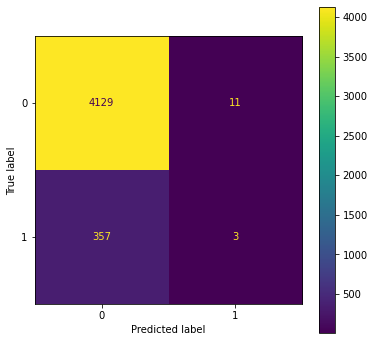

--- ROC AUC ---------------------------------------------------------------------------------------- 



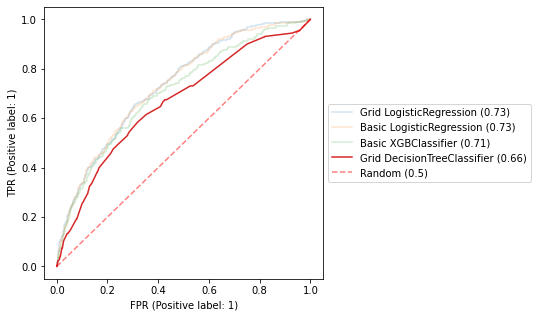

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



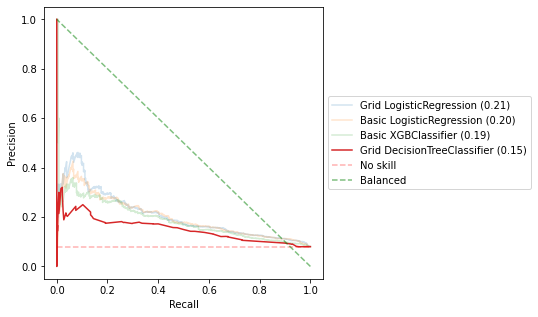

In [92]:
get_scores(model_name, **grd_dt, register=True)

#### Trouvons le meilleur seuil de séparation pour les prédiction *(sur la base du F1 score)*

In [93]:
f1_value, best_threshold = find_best_threshold(grd_dt['model'], X_train, y_train, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.25412339645693344) for this model is reached with a threshold of 0.255


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Grid DecisionTreeClassifier [w/thresholding] ---------------------------------------------------

             ROC_AUC : 0.6641
                  F1 : 0.1644
            ACCURACY : 0.8916
           PRECISION : 0.2143
              RECALL : 0.1333
   AVERAGE_PRECISION : 0.1487

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.93      0.96      0.94      4140
Prediction = 1       0.21      0.13      0.16       360

      accuracy                           0.89      4500
     macro avg       0.57      0.55      0.55      4500
  weighted avg       0.87  

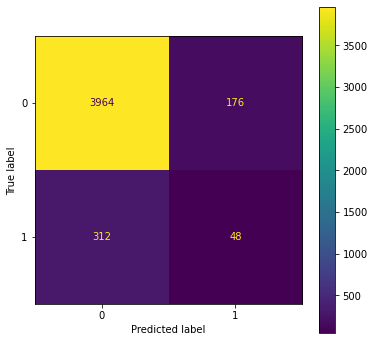

In [94]:
get_scores(f"{model_name} [w/thresholding]", **grd_dt, threshold=best_threshold, register=True, show_roccurves=False)

In [95]:
del grd_dt

## 3. KNN *(k-nearest neighbors)* Grid <a class="anchor" id="models_knn_grid"></a> [⇪](#menu)

In [96]:
param_grid = {
    'n_neighbors': range(1,35,2), # tous les chiffres impairs de 1 à 33 inclus
    #'weight_options': ['uniform', 'distance']
    'leaf_size': range(10,100,10),
}

In [97]:
model_name = "Grid KNeighborsClassifier"

grd_knn = fit_model(
    model_name,
    KNeighborsClassifier(n_jobs=-1), 
    param_grid=param_grid,  
    cv = skfold,
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | ROC_AUC: 0.5868
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | ROC_AUC: 0.5800
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | ROC_AUC: 0.5821
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | ROC_AUC: 0.5720
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | ROC_AUC: 0.5840

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- ROC_AUC: 0.5810 (std:0.0082)

----------------------------------------------------------------------------------------------------


In [98]:
grd_knn['grid'].best_params_

{'n_neighbors': 33, 'leaf_size': 80}

----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Grid KNeighborsClassifier ----------------------------------------------------------------------

             ROC_AUC : 0.6123
                  F1 : 0.0000
            ACCURACY : 0.9200
           PRECISION : 0.0000
              RECALL : 0.0000
   AVERAGE_PRECISION : 0.1150

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.92      1.00      0.96      4140
Prediction = 1       0.00      0.00      0.00       360

      accuracy                           0.92      4500
     macro avg       0.46      0.50      0.48      4500
  weighted avg       0.85  

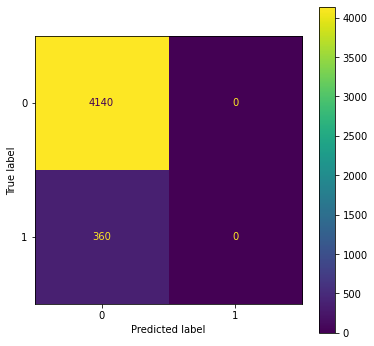

--- ROC AUC ---------------------------------------------------------------------------------------- 



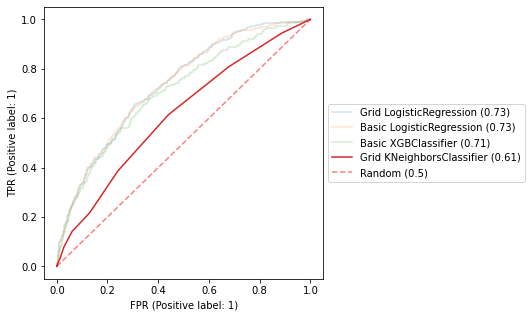

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



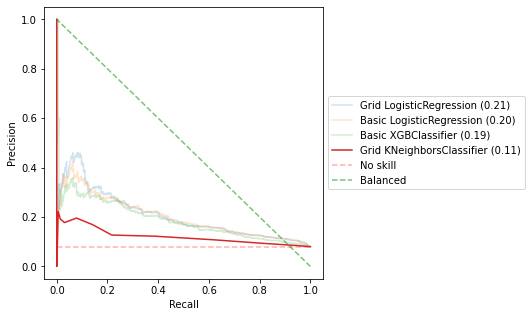

In [99]:
get_scores(model_name, **grd_knn, register=True)

#### Trouvons le meilleur seuil de séparation pour les prédiction *(sur la base du F1 score)*

In [100]:
f1_value, best_threshold = find_best_threshold(grd_knn['model'], X_train, y_train, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.23852242744063323) for this model is reached with a threshold of 0.181


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Grid KNeighborsClassifier [w/thresholding] -----------------------------------------------------

             ROC_AUC : 0.6123
                  F1 : 0.1541
            ACCURACY : 0.8756
           PRECISION : 0.1689
              RECALL : 0.1417
   AVERAGE_PRECISION : 0.1150

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.93      0.94      0.93      4140
Prediction = 1       0.17      0.14      0.15       360

      accuracy                           0.88      4500
     macro avg       0.55      0.54      0.54      4500
  weighted avg       0.87  

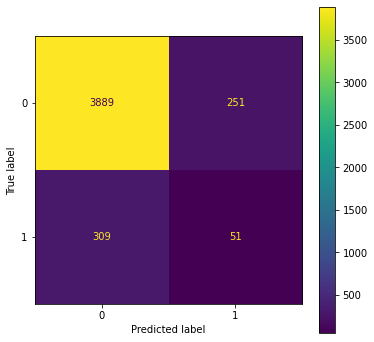

In [101]:
get_scores(f"{model_name} [w/thresholding]", **grd_knn, threshold=best_threshold, register=True, show_roccurves=False)

In [102]:
del grd_knn

## 4. Random Forest Grid <a class="anchor" id="models_random_forest_grid"></a> [⇪](#menu)

In [103]:
param_grid = {
    'random_state':[random_seed],
    'n_estimators' : np.arange(99,500,1),
    'criterion' :['gini', 'entropy'],
    'max_depth' : [None, *np.arange(1,20)],
    #'min_samples_split' : [None, *np.arange(1, 9)],
    #'min_samples_leaf' : [None, *np.arange(1, 9)],
    'max_features': [None, 'sqrt', 'log2'], #auto = sqrt
    #'max_leaf_nodes' : [None, *np.arange(1, 9)],
    'bootstrap': [True, False],
    'ccp_alpha': [0.0, 0.1, 0.01, 0.001],
}

In [104]:
model_name = "Grid RandomForestClassifier"

grd_rf = fit_model(
    model_name,
    RandomForestClassifier(n_jobs=-1), 
    param_grid=param_grid, 
    cv = skfold
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | ROC_AUC: 0.6196
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | ROC_AUC: 0.6215
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | ROC_AUC: 0.6157
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | ROC_AUC: 0.6219
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | ROC_AUC: 0.6109

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- ROC_AUC: 0.6179 (std:0.0054)

----------------------------------------------------------------------------------------------------


In [105]:
grd_rf['grid'].best_params_

{'random_state': 0,
 'n_estimators': 129,
 'max_features': 'sqrt',
 'max_depth': 11,
 'criterion': 'entropy',
 'ccp_alpha': 0.001,
 'bootstrap': False}

----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Grid RandomForestClassifier --------------------------------------------------------------------

             ROC_AUC : 0.7089
                  F1 : 0.0000
            ACCURACY : 0.9200
           PRECISION : 0.0000
              RECALL : 0.0000
   AVERAGE_PRECISION : 0.1913

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.92      1.00      0.96      4140
Prediction = 1       0.00      0.00      0.00       360

      accuracy                           0.92      4500
     macro avg       0.46      0.50      0.48      4500
  weighted avg       0.85  

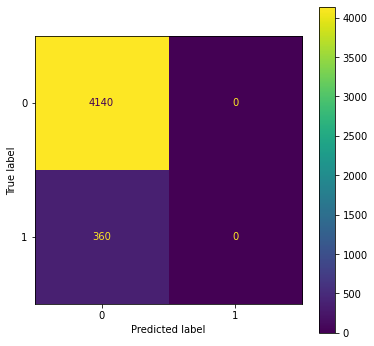

--- ROC AUC ---------------------------------------------------------------------------------------- 



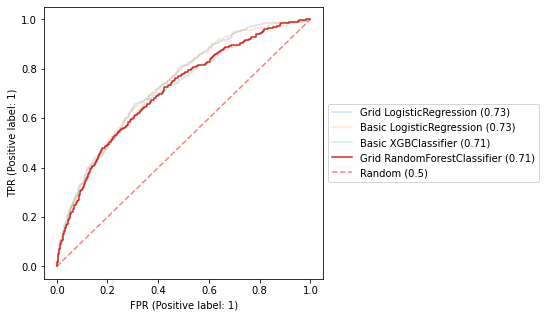

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



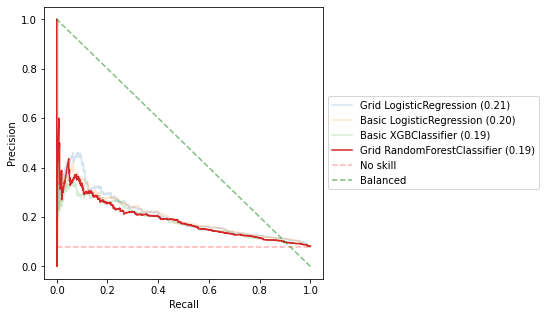

In [106]:
get_scores(model_name, **grd_rf, register=True)

#### Trouvons le meilleur seuil de séparation pour les prédictions *(sur la base du F1 score)*

In [107]:
f1_value, best_threshold = find_best_threshold(grd_rf['model'], X_train, y_train, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.13876563130294475) for this model is reached with a threshold of 0.136


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Grid RandomForestClassifier [w/thresholding] ---------------------------------------------------

             ROC_AUC : 0.7089
                  F1 : 0.1209
            ACCURACY : 0.9160
           PRECISION : 0.3714
              RECALL : 0.0722
   AVERAGE_PRECISION : 0.1913

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.92      0.99      0.96      4140
Prediction = 1       0.37      0.07      0.12       360

      accuracy                           0.92      4500
     macro avg       0.65      0.53      0.54      4500
  weighted avg       0.88  

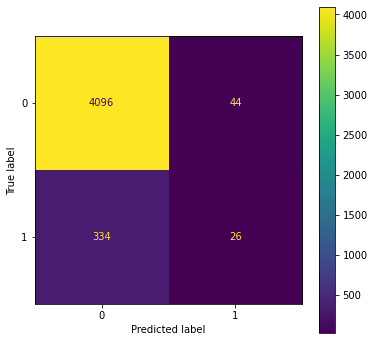

In [108]:
get_scores(f"{model_name} [w/thresholding]", **grd_rf, threshold=best_threshold, register=True, show_roccurves=False)

In [109]:
del grd_rf

## 5. XGBoost Classifier Grid<a class="anchor" id="models_xgboost_grid"></a> [⇪](#menu)

In [110]:
from xgboost import XGBClassifier

In [111]:
param_grid = {
    'seed':[random_seed],
    'objective':['binary:logistic'], # classification
    'eval_metric':['auc'], # classification
    'nthread':[-1],
    'max_depth': range (2, 100, 1),
    'n_estimators': range(60, 220, 10),
    'learning_rate': [None, 0.1, 0.01, 0.05]
}

In [112]:
model_name = "Grid XGBClassifier"

grd_xgb = fit_model(
    model_name,
    XGBClassifier(verbosity=1),
    param_grid=param_grid,
    cv = skfold
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | ROC_AUC: 0.7113
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | ROC_AUC: 0.7323
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | ROC_AUC: 0.7060
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | ROC_AUC: 0.7154
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | ROC_AUC: 0.7082

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- ROC_AUC: 0.7146 (std:0.0101)

----------------------------------------------------------------------------------------------------


In [113]:
grd_xgb['grid'].best_params_

{'seed': 0,
 'objective': 'binary:logistic',
 'nthread': -1,
 'n_estimators': 110,
 'max_depth': 7,
 'learning_rate': 0.1,
 'eval_metric': 'auc'}

----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Grid XGBClassifier -----------------------------------------------------------------------------

             ROC_AUC : 0.7255
                  F1 : 0.0375
            ACCURACY : 0.9202
           PRECISION : 0.5385
              RECALL : 0.0194
   AVERAGE_PRECISION : 0.2148

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.92      1.00      0.96      4140
Prediction = 1       0.54      0.02      0.04       360

      accuracy                           0.92      4500
     macro avg       0.73      0.51      0.50      4500
  weighted avg       0.89  

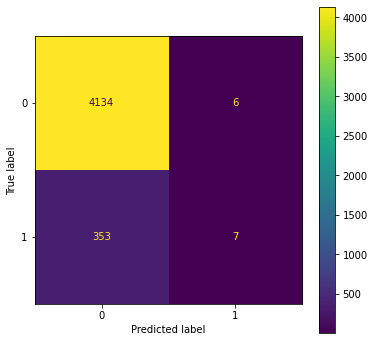

--- ROC AUC ---------------------------------------------------------------------------------------- 



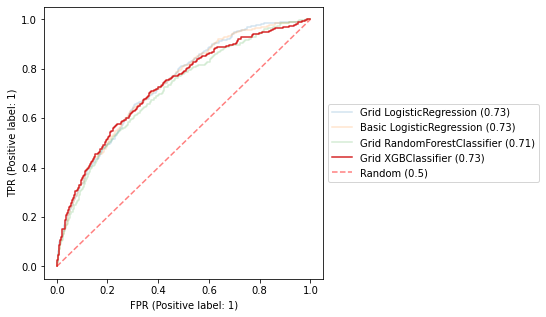

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



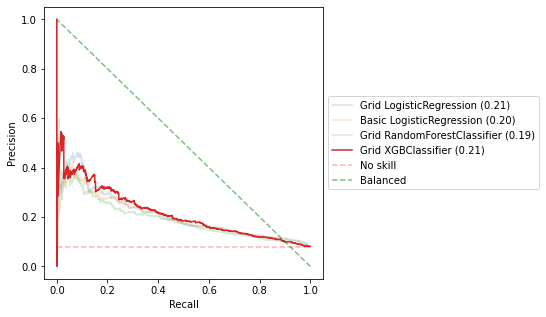

In [114]:
get_scores(model_name, **grd_xgb, register=True)

#### Trouvons le meilleur seuil de séparation pour les prédiction *(sur la base du F1 score)*

In [115]:
f1_value, best_threshold = find_best_threshold(grd_xgb['model'], X_train, y_train, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.46003752345215754) for this model is reached with a threshold of 0.46


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Grid XGBClassifier [w/thresholding] ------------------------------------------------------------

             ROC_AUC : 0.7255
                  F1 : 0.0519
            ACCURACY : 0.9189
           PRECISION : 0.4000
              RECALL : 0.0278
   AVERAGE_PRECISION : 0.2148

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.92      1.00      0.96      4140
Prediction = 1       0.40      0.03      0.05       360

      accuracy                           0.92      4500
     macro avg       0.66      0.51      0.50      4500
  weighted avg       0.88  

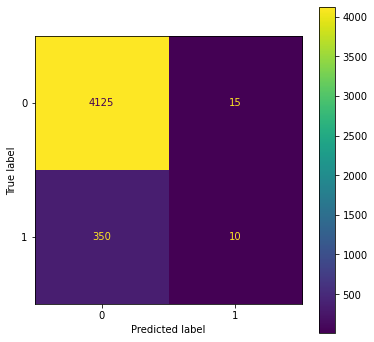

In [116]:
get_scores(f"{model_name} [w/thresholding]", **grd_xgb, threshold=best_threshold, register=True, show_roccurves=False)

In [117]:
del grd_xgb

## 6. Revue des scores <a class="anchor" id="models_grid_scores"></a> [⇪](#menu)

In [118]:
scores_df[ ~(scores_df.Method.str.contains('threshold')) & (scores_df.Method.str.contains('Grid')) ][['Method','ROC AUC', 'F1 score','Recall']]

,Method,ROC AUC,F1 score,Recall
13,Grid LogisticRegression,0.733309,0.005495,0.002778
15,Grid DecisionTreeClassifier,0.664093,0.016043,0.008333
17,Grid KNeighborsClassifier,0.612296,0.000000,0.000000
19,Grid RandomForestClassifier,0.708877,0.000000,0.000000
21,Grid XGBClassifier,0.725490,0.037534,0.019444


In [119]:
scores_df[ (scores_df.Method.str.contains('threshold')) & (scores_df.Method.str.contains('Grid')) ][['Method','ROC AUC', 'F1 score','Recall']]

,Method,ROC AUC,F1 score,Recall
14,Grid LogisticRegression [w/thresholding],0.733309,0.220665,0.175000
16,Grid DecisionTreeClassifier [w/thresholding],0.664093,0.164384,0.133333
18,Grid KNeighborsClassifier [w/thresholding],0.612296,0.154079,0.141667
20,Grid RandomForestClassifier [w/thresholding],0.708877,0.120930,0.072222
22,Grid XGBClassifier [w/thresholding],0.725490,0.051948,0.027778


In [120]:
sms.send("Gridsearch done", stop=False)

# Amélioration des modèles avec `class_weight` pour contre balancer le déséquilibrage des classes <a class="anchor" id="models_balanced"></a> [⇪](#menu)

## 1. Logistic Regression balanced with `class_weight` + Grid search<a class="anchor" id="models_linear_balanced"></a> [⇪](#menu)

In [121]:
param_grid = [
    {
        'class_weight':['balanced'],
        'random_state':[random_seed],
        'max_iter':[max_lr_iter],
        'solver' : ['lbfgs'],
        'penalty' : ['l2'], # none
        'C' : loguniform(1e-5, 1e2),
    },
    {
        'class_weight':['balanced'],
        'random_state':[random_seed],
        'max_iter':[max_lr_iter],
        'solver' : ['liblinear'],
        'penalty' : ['l1', 'l2'], # none
        'C' : loguniform(1e-5, 1e2),
    },
    {
        'class_weight':['balanced'],
        'random_state':[random_seed],
        'max_iter':[max_lr_iter],
        'solver' : ['saga'],
        'penalty' : ['elasticnet'], # none
        'C' : loguniform(1e-5, 1e2),
        'l1_ratio' : uniform(0,1)
    },
]

In [122]:
model_name = "Balanced LogisticRegression"

grd_log = fit_model(
    model_name,
    LogisticRegression(), 
    param_grid=param_grid,  
    cv = skfold
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | ROC_AUC: 0.7021
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | ROC_AUC: 0.7168
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | ROC_AUC: 0.7029
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | ROC_AUC: 0.7005
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | ROC_AUC: 0.6972

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- ROC_AUC: 0.7039 (std:0.0074)

----------------------------------------------------------------------------------------------------


In [123]:
grd_log['grid'].best_params_

{'C': 0.09469170308457578,
 'class_weight': 'balanced',
 'l1_ratio': 0.925596638292661,
 'max_iter': 3000,
 'penalty': 'elasticnet',
 'random_state': 0,
 'solver': 'saga'}

----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Balanced LogisticRegression --------------------------------------------------------------------

             ROC_AUC : 0.7323
                  F1 : 0.2418
            ACCURACY : 0.6724
           PRECISION : 0.1484
              RECALL : 0.6528
   AVERAGE_PRECISION : 0.2031

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.96      0.67      0.79      4140
Prediction = 1       0.15      0.65      0.24       360

      accuracy                           0.67      4500
     macro avg       0.55      0.66      0.52      4500
  weighted avg       0.89  

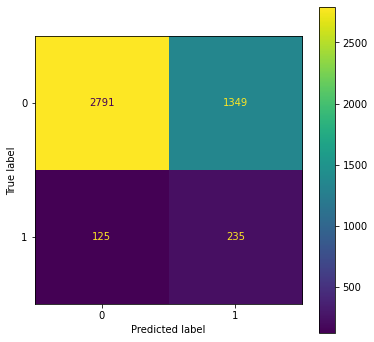

--- ROC AUC ---------------------------------------------------------------------------------------- 



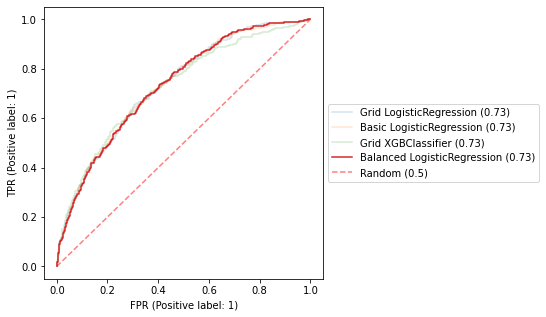

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



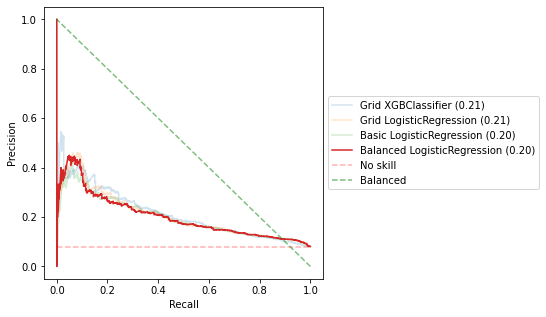

In [124]:
get_scores(model_name, **grd_log, register=True)

#### Trouvons le meilleur seuil de séparation pour les prédiction *(sur la base du F1 score)*

In [125]:
f1_value, best_threshold = find_best_threshold(grd_log['model'], X_train, y_train, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.27547256800368836) for this model is reached with a threshold of 0.552


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Balanced LogisticRegression [w/thresholding] ---------------------------------------------------

             ROC_AUC : 0.7323
                  F1 : 0.2534
            ACCURACY : 0.7329
           PRECISION : 0.1632
              RECALL : 0.5667
   AVERAGE_PRECISION : 0.2031

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.95      0.75      0.84      4140
Prediction = 1       0.16      0.57      0.25       360

      accuracy                           0.73      4500
     macro avg       0.56      0.66      0.55      4500
  weighted avg       0.89  

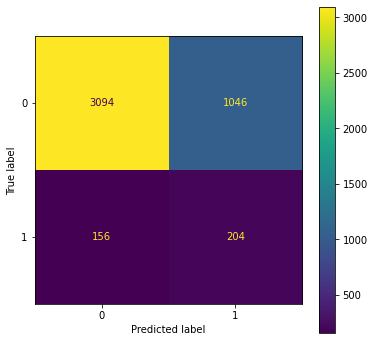

In [126]:
get_scores(f"{model_name} [w/thresholding]", **grd_log, threshold=best_threshold, register=True, show_roccurves=False)

In [127]:
del grd_log

## 2. Decision Tree balanced with `class_weight` + Grid search <a class="anchor" id="models_decision_tree_balanced"></a> [⇪](#menu)

In [128]:
param_grid = {
    'class_weight':['balanced'],
    'random_state':[random_seed],
    'criterion' :['gini', 'entropy'],
    'splitter' : ["best", "random"],
    'max_depth' : [None, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    #'min_samples_split' : [None, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    'min_samples_leaf' : [None, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    'max_features': [None, 'sqrt', 'log2'], # auto = sqrt
    #'max_leaf_nodes': [None, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    'ccp_alpha': [0.0, 0.1, 0.01, 0.001],
}

In [129]:
model_name = "Balanced DecisionTreeClassifier"

grd_dt = fit_model(
    model_name,
    DecisionTreeClassifier(), 
    param_grid=param_grid,
    cv = skfold
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | ROC_AUC: 0.5498
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | ROC_AUC: 0.5497
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | ROC_AUC: 0.5429
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | ROC_AUC: 0.5403
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | ROC_AUC: 0.5378

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- ROC_AUC: 0.5441 (std:0.0110)

----------------------------------------------------------------------------------------------------


In [130]:
grd_dt['grid'].best_params_

{'splitter': 'random',
 'random_state': 0,
 'min_samples_leaf': 6,
 'max_features': None,
 'max_depth': 7,
 'criterion': 'entropy',
 'class_weight': 'balanced',
 'ccp_alpha': 0.0}

----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Balanced DecisionTreeClassifier ----------------------------------------------------------------

             ROC_AUC : 0.6757
                  F1 : 0.2301
            ACCURACY : 0.6758
           PRECISION : 0.1420
              RECALL : 0.6056
   AVERAGE_PRECISION : 0.1559

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.95      0.68      0.79      4140
Prediction = 1       0.14      0.61      0.23       360

      accuracy                           0.68      4500
     macro avg       0.55      0.64      0.51      4500
  weighted avg       0.89  

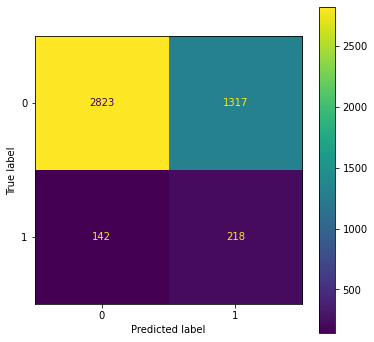

--- ROC AUC ---------------------------------------------------------------------------------------- 



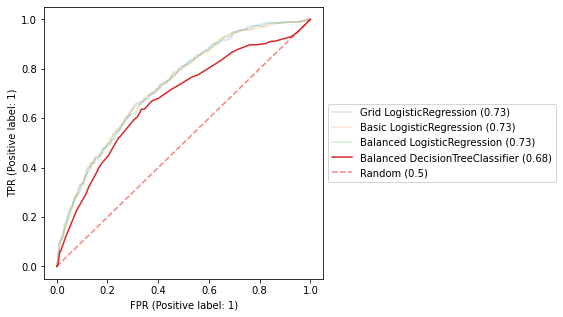

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



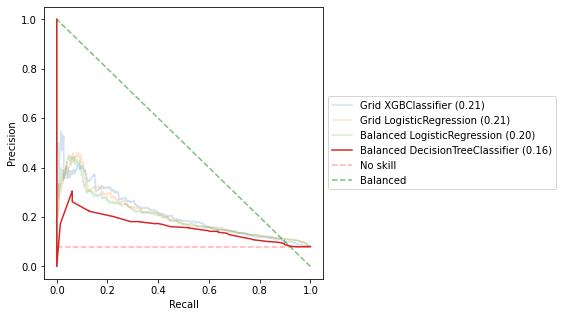

In [131]:
get_scores(model_name, **grd_dt, register=True)

#### Trouvons le meilleur seuil de séparation pour les prédiction *(sur la base du F1 score)*

In [132]:
f1_value, best_threshold = find_best_threshold(grd_dt['model'], X_train, y_train, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.2122884915396616) for this model is reached with a threshold of 0.36


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Balanced DecisionTreeClassifier [w/thresholding] -----------------------------------------------

             ROC_AUC : 0.6757
                  F1 : 0.1897
            ACCURACY : 0.4702
           PRECISION : 0.1081
              RECALL : 0.7750
   AVERAGE_PRECISION : 0.1559

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.96      0.44      0.61      4140
Prediction = 1       0.11      0.78      0.19       360

      accuracy                           0.47      4500
     macro avg       0.53      0.61      0.40      4500
  weighted avg       0.89  

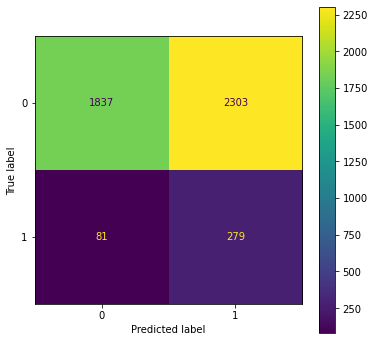

In [133]:
get_scores(f"{model_name} [w/thresholding]", **grd_dt, threshold=best_threshold, register=True, show_roccurves=False)

In [134]:
del grd_dt

## 3. Random Forest balanced with `class_weight` + Grid search<a class="anchor" id="models_random_forest_balanced"></a> [⇪](#menu)

In [135]:
param_grid = {
    'class_weight':['balanced'],
    'random_state':[random_seed],
    'n_estimators' : np.arange(99,500,1),
    'criterion' :['gini', 'entropy'],
    'max_depth' : [None, *np.arange(1,20)],
    #'min_samples_split' : [None, *np.arange(1, 9)],
    #'min_samples_leaf' : [None, *np.arange(1, 9)],
    'max_features': [None, 'sqrt', 'log2'], #auto = sqrt
    #'max_leaf_nodes' : [None, *np.arange(1, 9)],
    'bootstrap': [True, False],
    'ccp_alpha': [0.0, 0.1, 0.01, 0.001],
}

In [136]:
model_name = "Balanced RandomForestClassifier"

grd_rf = fit_model(
    model_name,
    RandomForestClassifier(n_jobs=-1), 
    param_grid=param_grid, 
    cv = skfold
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | ROC_AUC: 0.6796
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | ROC_AUC: 0.6875
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | ROC_AUC: 0.6767
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | ROC_AUC: 0.6808
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | ROC_AUC: 0.6783

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- ROC_AUC: 0.6806 (std:0.0070)

----------------------------------------------------------------------------------------------------


In [137]:
grd_rf['grid'].best_params_

{'random_state': 0,
 'n_estimators': 490,
 'max_features': 'sqrt',
 'max_depth': 17,
 'criterion': 'gini',
 'class_weight': 'balanced',
 'ccp_alpha': 0.001,
 'bootstrap': False}

----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Balanced RandomForestClassifier ----------------------------------------------------------------

             ROC_AUC : 0.7138
                  F1 : 0.2407
            ACCURACY : 0.6929
           PRECISION : 0.1500
              RECALL : 0.6083
   AVERAGE_PRECISION : 0.1946

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.95      0.70      0.81      4140
Prediction = 1       0.15      0.61      0.24       360

      accuracy                           0.69      4500
     macro avg       0.55      0.65      0.52      4500
  weighted avg       0.89  

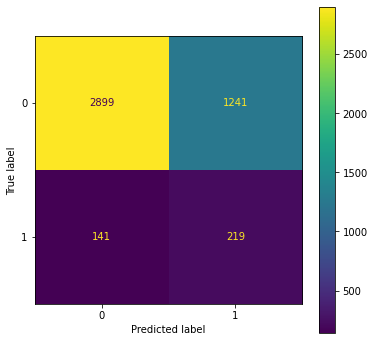

--- ROC AUC ---------------------------------------------------------------------------------------- 



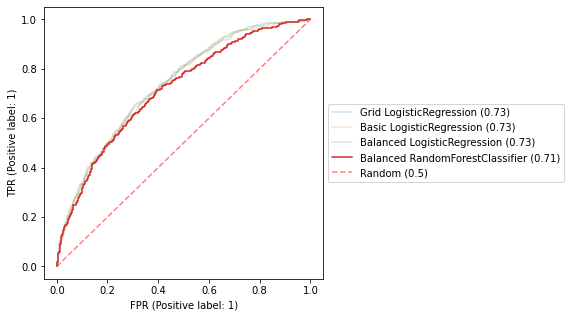

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



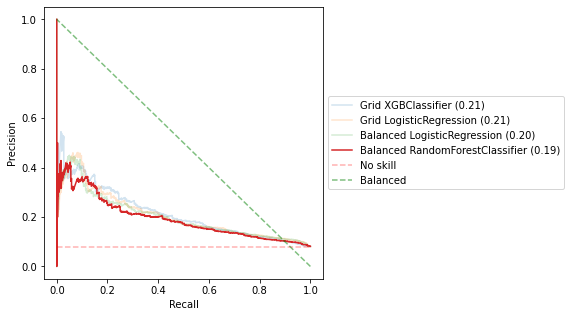

In [138]:
get_scores(model_name, **grd_rf, register=True)

#### Trouvons le meilleur seuil de séparation pour les prédiction *(sur la base du F1 score)*

In [139]:
f1_value, best_threshold = find_best_threshold(grd_rf['model'], X_train, y_train, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.30924322021865686) for this model is reached with a threshold of 0.539


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Balanced RandomForestClassifier [w/thresholding] -----------------------------------------------

             ROC_AUC : 0.7138
                  F1 : 0.2589
            ACCURACY : 0.7876
           PRECISION : 0.1796
              RECALL : 0.4639
   AVERAGE_PRECISION : 0.1946

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.95      0.82      0.88      4140
Prediction = 1       0.18      0.46      0.26       360

      accuracy                           0.79      4500
     macro avg       0.56      0.64      0.57      4500
  weighted avg       0.88  

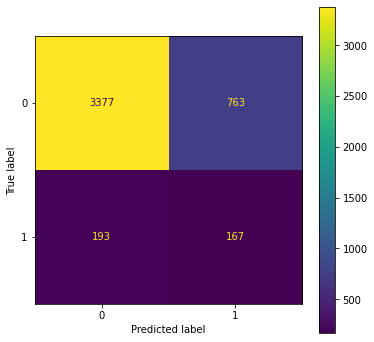

In [140]:
get_scores(f"{model_name} [w/thresholding]", **grd_rf, threshold=best_threshold, register=True, show_roccurves=False)

In [141]:
del grd_rf

## 4. XGBoost Classifier balanced with `class_weight` + Grid search<a class="anchor" id="models_xgboost_balanced"></a> [⇪](#menu)

In [142]:
from collections import Counter
counter = Counter(y_train)
scale_weigth = counter[0] / counter[1]

In [143]:
param_grid = {
    'scale_pos_weight':[scale_weigth],
    'seed':[random_seed],
    'objective':['binary:logistic'], # classification
    'eval_metric':['auc'], # classification
    'nthread':[-1],
    'max_depth': range (2, 100, 1),
    'n_estimators': range(60, 220, 10),
    'learning_rate': [None, 0.1, 0.01, 0.05]
}

In [144]:
model_name = "Balanced XGBClassifier"

grd_xgb = fit_model(
    model_name,
    XGBClassifier(verbosity=1),
    param_grid=param_grid,
    cv = skfold
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | ROC_AUC: 0.7048
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | ROC_AUC: 0.7207
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | ROC_AUC: 0.6899
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | ROC_AUC: 0.7045
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | ROC_AUC: 0.6930

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- ROC_AUC: 0.7026 (std:0.0121)

----------------------------------------------------------------------------------------------------


In [145]:
grd_xgb['grid'].best_params_

{'seed': 0,
 'scale_pos_weight': 11.481644640234949,
 'objective': 'binary:logistic',
 'nthread': -1,
 'n_estimators': 210,
 'max_depth': 66,
 'learning_rate': 0.1,
 'eval_metric': 'auc'}

----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Balanced XGBClassifier -------------------------------------------------------------------------

             ROC_AUC : 0.7091
                  F1 : 0.1218
            ACCURACY : 0.9167
           PRECISION : 0.3881
              RECALL : 0.0722
   AVERAGE_PRECISION : 0.1950

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.92      0.99      0.96      4140
Prediction = 1       0.39      0.07      0.12       360

      accuracy                           0.92      4500
     macro avg       0.66      0.53      0.54      4500
  weighted avg       0.88  

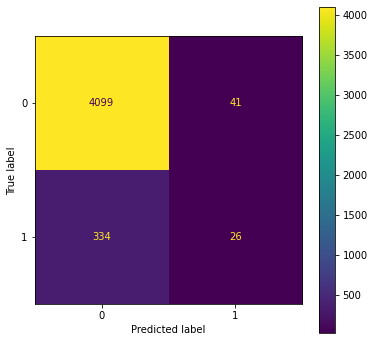

--- ROC AUC ---------------------------------------------------------------------------------------- 



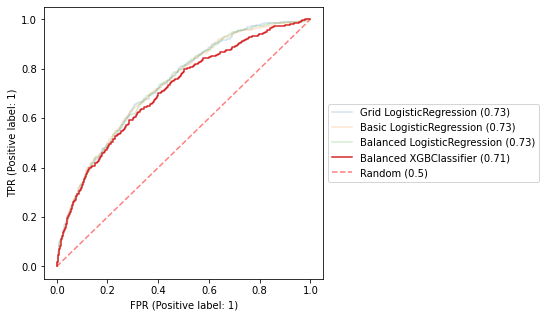

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



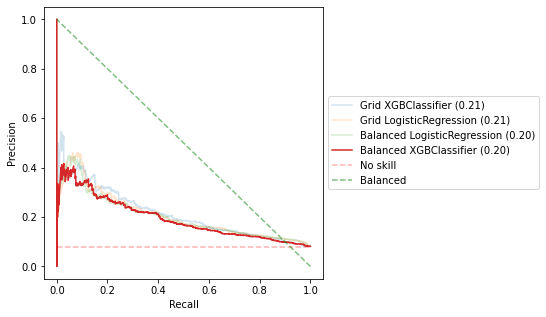

In [146]:
get_scores(model_name, **grd_xgb, register=True)

#### Trouvons le meilleur seuil de séparation pour les prédiction *(sur la base du F1 score)*

In [147]:
f1_value, best_threshold = find_best_threshold(grd_xgb['model'], X_train, y_train, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.9990200881920628) for this model is reached with a threshold of 0.994


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- Balanced XGBClassifier [w/thresholding] --------------------------------------------------------

             ROC_AUC : 0.7091
                  F1 : 0.0000
            ACCURACY : 0.9200
           PRECISION : 0.0000
              RECALL : 0.0000
   AVERAGE_PRECISION : 0.1950

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.92      1.00      0.96      4140
Prediction = 1       0.00      0.00      0.00       360

      accuracy                           0.92      4500
     macro avg       0.46      0.50      0.48      4500
  weighted avg       0.85  

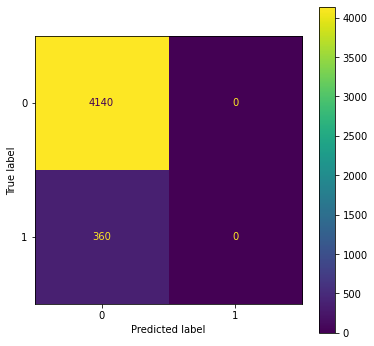

In [148]:
get_scores(f"{model_name} [w/thresholding]", **grd_xgb, threshold=best_threshold, register=True, show_roccurves=False)

In [149]:
del grd_xgb

## 5. Revue des scores <a class="anchor" id="models_balanced_scores"></a> [⇪](#menu)

In [150]:
scores_df[ ~(scores_df.Method.str.contains('threshold')) & (scores_df.Method.str.contains('Balanced')) ][['Method','ROC AUC', 'F1 score','Recall']]

,Method,ROC AUC,F1 score,Recall
23,Balanced LogisticRegression,0.732336,0.241770,0.652778
25,Balanced DecisionTreeClassifier,0.675670,0.230079,0.605556
27,Balanced RandomForestClassifier,0.713771,0.240659,0.608333
29,Balanced XGBClassifier,0.709113,0.121780,0.072222


In [151]:
scores_df[ (scores_df.Method.str.contains('threshold')) & (scores_df.Method.str.contains('Balanced')) ][['Method','ROC AUC', 'F1 score','Recall']]

,Method,ROC AUC,F1 score,Recall
24,Balanced LogisticRegression [w/thresholding],0.732336,0.253416,0.566667
26,Balanced DecisionTreeClassifier [w/thresholding],0.675670,0.189667,0.775000
28,Balanced RandomForestClassifier [w/thresholding],0.713771,0.258915,0.463889
30,Balanced XGBClassifier [w/thresholding],0.709113,0.000000,0.000000


In [152]:
sms.send("Balanced done", stop=False)

# Amélioration des modèles avec `SMOT` pour contre balancer le déséquilibrage des classes <a class="anchor" id="models_smot"></a> [⇪](#menu)

In [46]:
from imblearn.over_sampling import SMOTE

In [47]:
#Use SMOTE to oversample the minority class
oversample = SMOTE(random_state=random_seed)
over_x_train, over_y_train = oversample.fit_resample(X_train,y_train)

In [48]:
over_y_train.value_counts()

1    23457
0    23457
Name: TARGET, dtype: int64

In [49]:
y_test.value_counts()

0    4140
1     360
Name: TARGET, dtype: int64

## 1. Logistic Regression balanced with `SMOT` + Grid search<a class="anchor" id="models_linear_smot"></a> [⇪](#menu)

In [157]:
param_grid = [
    {
        'random_state':[random_seed],
        'max_iter':[max_lr_iter],
        'solver' : ['lbfgs'],
        'penalty' : ['l2'], # none
        'C' : loguniform(1e-5, 1e2),
    },
    {
        'random_state':[random_seed],
        'max_iter':[max_lr_iter],
        'solver' : ['liblinear'],
        'penalty' : ['l1', 'l2'], # none
        'C' : loguniform(1e-5, 1e2),
    },
    {
        'random_state':[random_seed],
        'max_iter':[max_lr_iter],
        'solver' : ['saga'],
        'penalty' : ['elasticnet'], # none
        'C' : loguniform(1e-5, 1e2),
        'l1_ratio' : uniform(0,1)
    },
]

In [158]:
model_name = "SMOT LogisticRegression"

grd_log = fit_model(
    model_name,
    LogisticRegression(), 
    param_grid=param_grid,  
    cv = skfold,
    X_ref=over_x_train,
    y_ref=over_y_train,
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | ROC_AUC: 0.7497
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | ROC_AUC: 0.7490
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | ROC_AUC: 0.7434
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | ROC_AUC: 0.7528
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | ROC_AUC: 0.7489

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- ROC_AUC: 0.7487 (std:0.0031)

----------------------------------------------------------------------------------------------------


In [159]:
grd_log['grid'].best_params_

{'C': 55.67232047731104,
 'max_iter': 3000,
 'penalty': 'l2',
 'random_state': 0,
 'solver': 'lbfgs'}

----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- SMOT LogisticRegression ------------------------------------------------------------------------

             ROC_AUC : 0.7194
                  F1 : 0.2358
            ACCURACY : 0.6831
           PRECISION : 0.1461
              RECALL : 0.6111
   AVERAGE_PRECISION : 0.1895

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.95      0.69      0.80      4140
Prediction = 1       0.15      0.61      0.24       360

      accuracy                           0.68      4500
     macro avg       0.55      0.65      0.52      4500
  weighted avg       0.89  

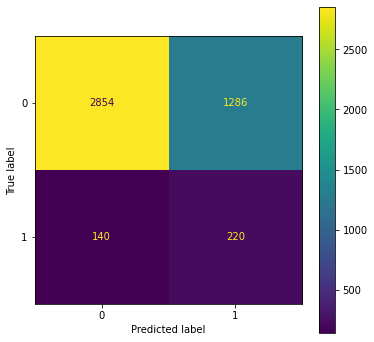

--- ROC AUC ---------------------------------------------------------------------------------------- 



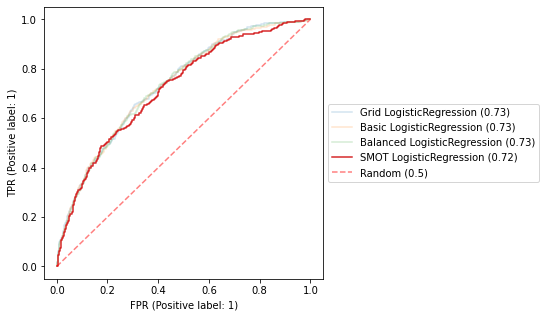

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



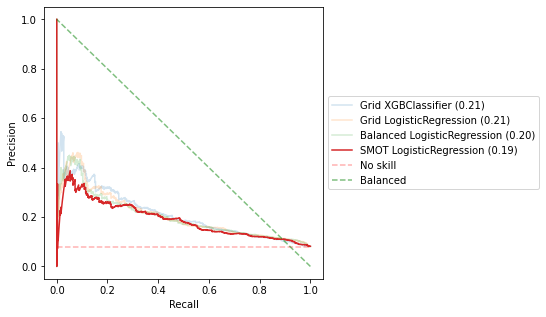

In [160]:
get_scores(model_name, **grd_log, register=True)

#### Trouvons le meilleur seuil de séparation pour les prédiction *(sur la base du F1 score)*

In [161]:
f1_value, best_threshold = find_best_threshold(grd_log['model'], X_train, y_train, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.20953285451415682) for this model is reached with a threshold of 0.302


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- SMOT LogisticRegression [w/thresholding] -------------------------------------------------------

             ROC_AUC : 0.7194
                  F1 : 0.2022
            ACCURACY : 0.4687
           PRECISION : 0.1149
              RECALL : 0.8417
   AVERAGE_PRECISION : 0.1895

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.97      0.44      0.60      4140
Prediction = 1       0.11      0.84      0.20       360

      accuracy                           0.47      4500
     macro avg       0.54      0.64      0.40      4500
  weighted avg       0.90  

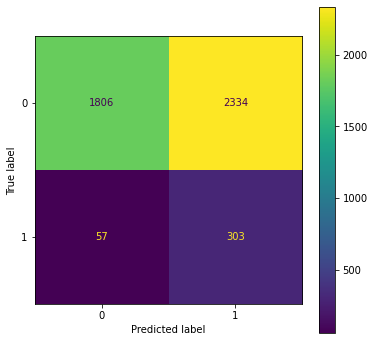

In [162]:
get_scores(f"{model_name} [w/thresholding]", **grd_log, threshold=best_threshold, register=True, show_roccurves=False)

In [163]:
del grd_log

## 2. Decision Tree balanced with `SMOT` + Grid search <a class="anchor" id="models_decision_tree_smot"></a> [⇪](#menu)

In [50]:
param_grid = {
    'random_state':[random_seed],
    'criterion' :['gini', 'entropy'],
    'splitter' : ["best", "random"],
    'max_depth' : [None, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    #'min_samples_split' : [None, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    'min_samples_leaf' : [None, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    'max_features': [None, 'sqrt', 'log2'], # auto = sqrt
    #'max_leaf_nodes': [None, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    'ccp_alpha': [0.0, 0.1, 0.01, 0.001],
}

In [51]:
model_name = "SMOT DecisionTreeClassifier"

grd_dt = fit_model(
    model_name,
    DecisionTreeClassifier(), 
    param_grid=param_grid,
    cv = skfold,
    X_ref=over_x_train,
    y_ref=over_y_train,
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | ROC_AUC: 0.6258
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | ROC_AUC: 0.6324
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | ROC_AUC: 0.6307
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | ROC_AUC: 0.6250
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | ROC_AUC: 0.6227

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- ROC_AUC: 0.6273 (std:0.0076)

----------------------------------------------------------------------------------------------------


In [52]:
grd_dt['grid'].best_params_

{'splitter': 'random',
 'random_state': 0,
 'min_samples_leaf': 6,
 'max_features': None,
 'max_depth': 7,
 'criterion': 'entropy',
 'ccp_alpha': 0.0}

----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- SMOT DecisionTreeClassifier --------------------------------------------------------------------

             ROC_AUC : 0.6246
                  F1 : 0.1880
            ACCURACY : 0.6967
           PRECISION : 0.1196
              RECALL : 0.4389
   AVERAGE_PRECISION : 0.1279

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.94      0.72      0.81      4140
Prediction = 1       0.12      0.44      0.19       360

      accuracy                           0.70      4500
     macro avg       0.53      0.58      0.50      4500
  weighted avg       0.87  

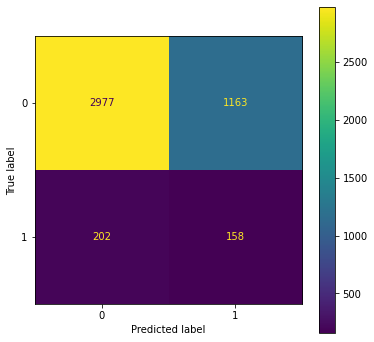

--- ROC AUC ---------------------------------------------------------------------------------------- 



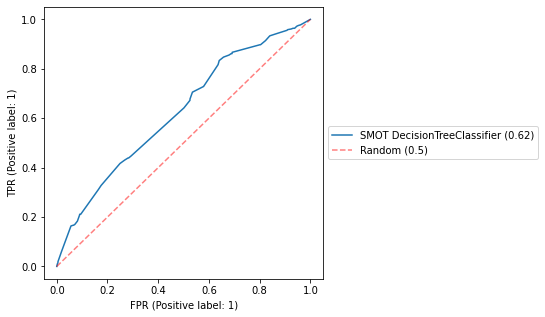

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



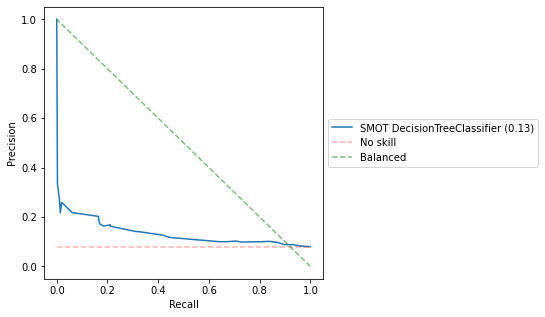

In [53]:
get_scores(model_name, **grd_dt, register=True)

#### Trouvons le meilleur seuil de séparation pour les prédiction *(sur la base du F1 score)*

In [54]:
f1_value, best_threshold = find_best_threshold(grd_dt['model'], X_train, y_train, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.18813105295693386) for this model is reached with a threshold of 0.233


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- SMOT DecisionTreeClassifier [w/thresholding] ---------------------------------------------------

             ROC_AUC : 0.6246
                  F1 : 0.1770
            ACCURACY : 0.3636
           PRECISION : 0.0987
              RECALL : 0.8556
   AVERAGE_PRECISION : 0.1279

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.96      0.32      0.48      4140
Prediction = 1       0.10      0.86      0.18       360

      accuracy                           0.36      4500
     macro avg       0.53      0.59      0.33      4500
  weighted avg       0.89  

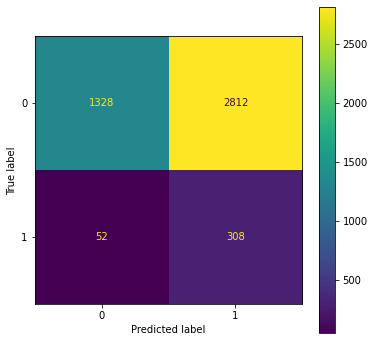

In [55]:
get_scores(f"{model_name} [w/thresholding]", **grd_dt, threshold=best_threshold, register=True, show_roccurves=False)

In [56]:
del grd_dt

## 3. KNN *(k-nearest neighbors)* with `SMOT` + Grid search <a class="anchor" id="models_knn_smot"></a> [⇪](#menu)

In [57]:
param_grid = {
    'n_neighbors': range(1,35,2), # tous les chiffres impairs de 1 à 33 inclus
    #'weight_options': ['uniform', 'distance']
    'leaf_size': range(10,100,10),
}

In [58]:
model_name = "SMOT KNeighborsClassifier"

grd_knn = fit_model(
    model_name,
    KNeighborsClassifier(n_jobs=-1), 
    param_grid=param_grid,  
    cv = skfold,
    X_ref=over_x_train,
    y_ref=over_y_train,
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | ROC_AUC: 0.9085
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | ROC_AUC: 0.9104
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | ROC_AUC: 0.9127
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | ROC_AUC: 0.9175
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | ROC_AUC: 0.9089

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- ROC_AUC: 0.9116 (std:0.0036)

----------------------------------------------------------------------------------------------------


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- SMOT KNeighborsClassifier ----------------------------------------------------------------------

             ROC_AUC : 0.5630
                  F1 : 0.1598
            ACCURACY : 0.5678
           PRECISION : 0.0946
              RECALL : 0.5139
   AVERAGE_PRECISION : 0.0933

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.93      0.57      0.71      4140
Prediction = 1       0.09      0.51      0.16       360

      accuracy                           0.57      4500
     macro avg       0.51      0.54      0.43      4500
  weighted avg       0.86  

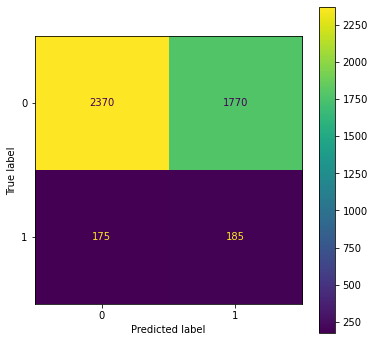

--- ROC AUC ---------------------------------------------------------------------------------------- 



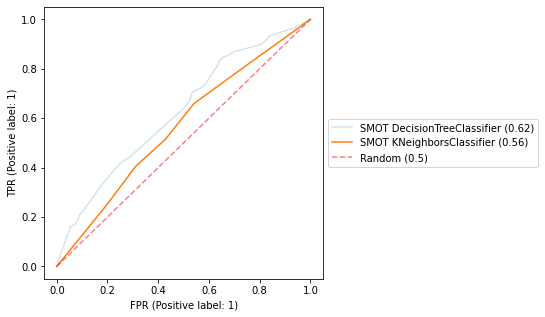

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



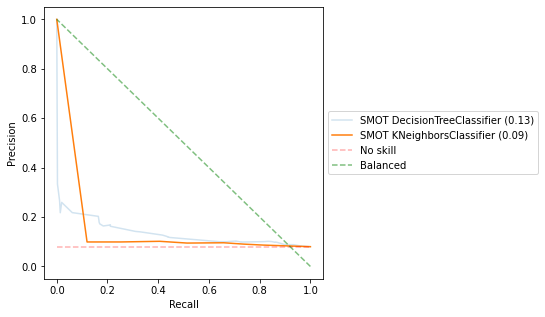

In [59]:
get_scores(model_name, **grd_knn, register=True)

#### Trouvons le meilleur seuil de séparation pour les prédiction *(sur la base du F1 score)*

In [60]:
f1_value, best_threshold = find_best_threshold(grd_knn['model'], X_train, y_train, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.9795204795204795) for this model is reached with a threshold of 0.98


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- SMOT KNeighborsClassifier [w/thresholding] -----------------------------------------------------

             ROC_AUC : 0.5630
                  F1 : 0.1083
            ACCURACY : 0.8427
           PRECISION : 0.0991
              RECALL : 0.1194
   AVERAGE_PRECISION : 0.0933

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.92      0.91      0.91      4140
Prediction = 1       0.10      0.12      0.11       360

      accuracy                           0.84      4500
     macro avg       0.51      0.51      0.51      4500
  weighted avg       0.86  

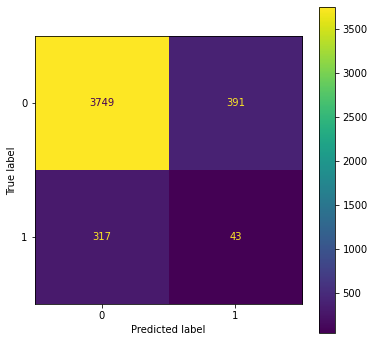

In [61]:
get_scores(f"{model_name} [w/thresholding]", **grd_knn, threshold=best_threshold, register=True, show_roccurves=False)

In [62]:
del grd_knn

## 4. Random Forest balanced with `SMOT` + Grid search<a class="anchor" id="models_random_forest_smot"></a> [⇪](#menu)

In [63]:
param_grid = {
    'random_state':[random_seed],
    'n_estimators' : np.arange(99,500,1),
    'criterion' :['gini', 'entropy'],
    'max_depth' : [None, *np.arange(1,20)],
    #'min_samples_split' : [None, *np.arange(1, 9)],
    #'min_samples_leaf' : [None, *np.arange(1, 9)],
    'max_features': [None, 'sqrt', 'log2'], #auto = sqrt
    #'max_leaf_nodes' : [None, *np.arange(1, 9)],
    'bootstrap': [True, False],
    'ccp_alpha': [0.0, 0.1, 0.01, 0.001],
}

In [64]:
model_name = "SMOT RandomForestClassifier"

grd_rf = fit_model(
    model_name,
    RandomForestClassifier(n_jobs=-1), 
    param_grid=param_grid, 
    cv = skfold,
    X_ref=over_x_train,
    y_ref=over_y_train,
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | ROC_AUC: 0.8551
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | ROC_AUC: 0.8509
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | ROC_AUC: 0.8498
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | ROC_AUC: 0.8580
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | ROC_AUC: 0.8542

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- ROC_AUC: 0.8536 (std:0.0037)

----------------------------------------------------------------------------------------------------


In [65]:
grd_rf['grid'].best_params_

{'random_state': 0,
 'n_estimators': 315,
 'max_features': 'log2',
 'max_depth': 15,
 'criterion': 'gini',
 'ccp_alpha': 0.0,
 'bootstrap': False}

----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- SMOT RandomForestClassifier --------------------------------------------------------------------

             ROC_AUC : 0.6687
                  F1 : 0.1760
            ACCURACY : 0.8856
           PRECISION : 0.2075
              RECALL : 0.1528
   AVERAGE_PRECISION : 0.1559

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.93      0.95      0.94      4140
Prediction = 1       0.21      0.15      0.18       360

      accuracy                           0.89      4500
     macro avg       0.57      0.55      0.56      4500
  weighted avg       0.87  

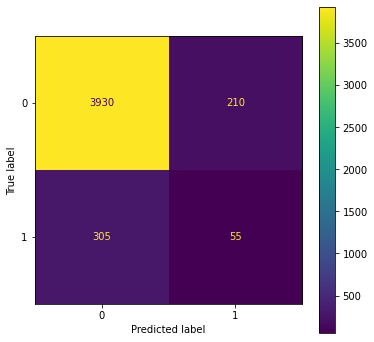

--- ROC AUC ---------------------------------------------------------------------------------------- 



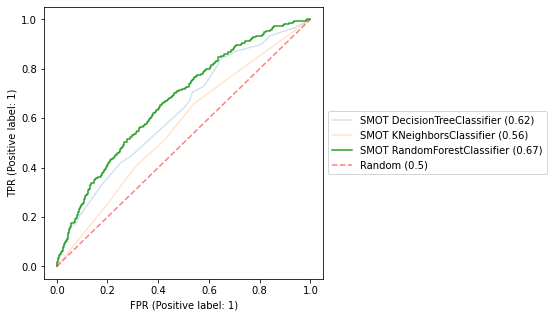

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



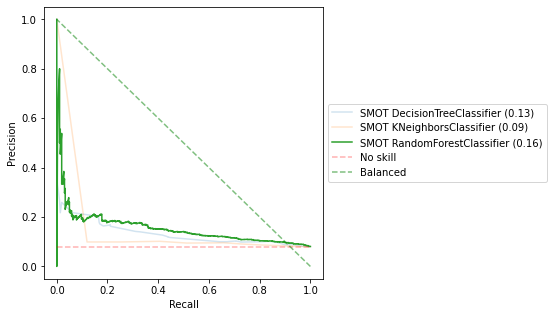

In [66]:
get_scores(model_name, **grd_rf, register=True)

#### Trouvons le meilleur seuil de séparation pour les prédiction *(sur la base du F1 score)*

In [67]:
f1_value, best_threshold = find_best_threshold(grd_rf['model'], X_train, y_train, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.5950625200384738) for this model is reached with a threshold of 0.596


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- SMOT RandomForestClassifier [w/thresholding] ---------------------------------------------------

             ROC_AUC : 0.6687
                  F1 : 0.0588
            ACCURACY : 0.9147
           PRECISION : 0.2500
              RECALL : 0.0333
   AVERAGE_PRECISION : 0.1559

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.92      0.99      0.96      4140
Prediction = 1       0.25      0.03      0.06       360

      accuracy                           0.91      4500
     macro avg       0.59      0.51      0.51      4500
  weighted avg       0.87  

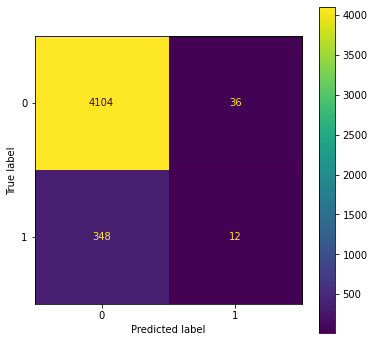

In [68]:
get_scores(f"{model_name} [w/thresholding]", **grd_rf, threshold=best_threshold, register=True, show_roccurves=False)

In [69]:
del grd_rf

## 5. XGBoost Classifier balanced with `SMOT` + Grid search<a class="anchor" id="models_xgboost_smot"></a> [⇪](#menu)

In [70]:
param_grid = {
    'seed':[random_seed],
    'objective':['binary:logistic'], # classification
    'eval_metric':['auc'], # classification
    'nthread':[-1],
    'max_depth': range (2, 100, 1),
    'n_estimators': range(60, 220, 10),
    'learning_rate': [None, 0.1, 0.01, 0.05]
}

In [71]:
model_name = "SMOT XGBClassifier"

grd_xgb = fit_model(
    model_name,
    XGBClassifier(verbosity=1),
    param_grid=param_grid,
    cv = skfold,
    X_ref=over_x_train,
    y_ref=over_y_train,
)

----------------------------------------------------------------------------------------------------
FOLD-1   TEST scores | ROC_AUC: 0.9830
----------------------------------------------------------------------------------------------------
FOLD-2   TEST scores | ROC_AUC: 0.9804
----------------------------------------------------------------------------------------------------
FOLD-3   TEST scores | ROC_AUC: 0.9804
----------------------------------------------------------------------------------------------------
FOLD-4   TEST scores | ROC_AUC: 0.9827
----------------------------------------------------------------------------------------------------
FOLD-5   TEST scores | ROC_AUC: 0.9802

------------------------------------ TEST-CV-SPLIT MEAN SCORES -------------------------------------

- ROC_AUC: 0.9813 (std:0.0013)

----------------------------------------------------------------------------------------------------


In [72]:
grd_xgb['grid'].best_params_

{'seed': 0,
 'objective': 'binary:logistic',
 'nthread': -1,
 'n_estimators': 180,
 'max_depth': 74,
 'learning_rate': 0.1,
 'eval_metric': 'auc'}

----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- SMOT XGBClassifier -----------------------------------------------------------------------------

             ROC_AUC : 0.7043
                  F1 : 0.0420
            ACCURACY : 0.9189
           PRECISION : 0.3810
              RECALL : 0.0222
   AVERAGE_PRECISION : 0.1841

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.92      1.00      0.96      4140
Prediction = 1       0.38      0.02      0.04       360

      accuracy                           0.92      4500
     macro avg       0.65      0.51      0.50      4500
  weighted avg       0.88  

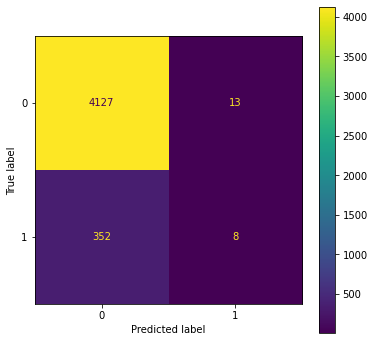

--- ROC AUC ---------------------------------------------------------------------------------------- 



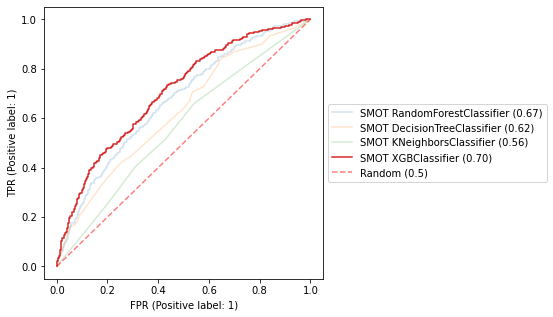

--- PRECISION RECALL AUC --------------------------------------------------------------------------- 



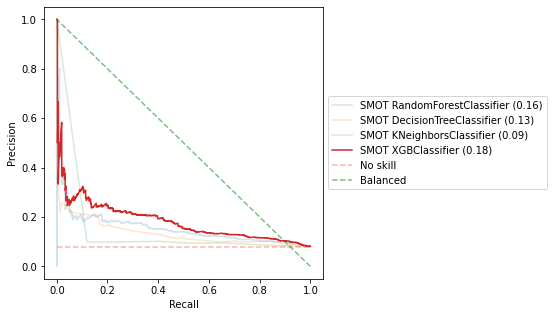

In [73]:
get_scores(model_name, **grd_xgb, register=True)

#### Trouvons le meilleur seuil de séparation pour les prédiction *(sur la base du F1 score)*

In [74]:
f1_value, best_threshold = find_best_threshold(grd_xgb['model'], X_train, y_train, f1_score)
print(f"The best F1 score ({f1_value}) for this model is reached with a threshold of {best_threshold}")

The best F1 score (0.9455483870967741) for this model is reached with a threshold of 0.9430000000000001


----------------------------------------------------------------------------------------------------
          These information are based on the best estimator of the above cross-validation           
----------------------------------------------------------------------------------------------------

--- SMOT XGBClassifier [w/thresholding] ------------------------------------------------------------

             ROC_AUC : 0.7043
                  F1 : 0.0000
            ACCURACY : 0.9200
           PRECISION : 0.0000
              RECALL : 0.0000
   AVERAGE_PRECISION : 0.1841

--- Classification Report -------------------------------------------------------------------------- 

                 precision    recall  f1-score   support

Prediction = 0       0.92      1.00      0.96      4140
Prediction = 1       0.00      0.00      0.00       360

      accuracy                           0.92      4500
     macro avg       0.46      0.50      0.48      4500
  weighted avg       0.85  

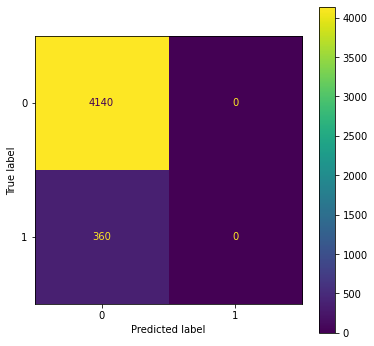

In [75]:
get_scores(f"{model_name} [w/thresholding]", **grd_xgb, threshold=best_threshold, register=True, show_roccurves=False)

In [76]:
del grd_xgb

## 6. Revue des scores <a class="anchor" id="models_balanced_scores"></a> [⇪](#menu)

In [83]:
scores_df[ ~(scores_df.Method.str.contains('threshold')) & (scores_df.Method.str.contains('SMOT')) ][['Method','ROC AUC', 'F1 score','Recall']]

,Method,ROC AUC,F1 score,Recall
31,SMOT LogisticRegression,0.719372,0.235798,0.611111
33,SMOT DecisionTreeClassifier,0.624586,0.187983,0.438889
35,SMOT KNeighborsClassifier,0.562958,0.159827,0.513889
37,SMOT RandomForestClassifier,0.668667,0.176000,0.152778
39,SMOT XGBClassifier,0.704255,0.041995,0.022222


In [84]:
scores_df[ (scores_df.Method.str.contains('threshold')) & (scores_df.Method.str.contains('SMOT')) ][['Method','ROC AUC', 'F1 score','Recall']]

,Method,ROC AUC,F1 score,Recall
32,SMOT LogisticRegression [w/thresholding],0.719372,0.202202,0.841667
34,SMOT DecisionTreeClassifier [w/thresholding],0.624586,0.177011,0.855556
36,SMOT KNeighborsClassifier [w/thresholding],0.562958,0.108312,0.119444
38,SMOT RandomForestClassifier [w/thresholding],0.668667,0.058824,0.033333
40,SMOT XGBClassifier [w/thresholding],0.704255,0.000000,0.000000


# Selection des 2 meilleurs modèles pour la suite du projet <a class="anchor" id="models_choice"></a> [⇪](#menu)

## Regardons d'abord l'ensemble des modèles testés

In [82]:
scores_df

,Method,threshold,params,ROC AUC,PR AUC,F1 score,Accuracy,Precision,Recall,TP,TN,FP,FN,Training time,Inference time
0,DummyClassifier,NaN,"{'random_state': [0], 'strategy': ['stratified']}",0.490519,0.078885,0.066578,0.844222,0.063939,0.069444,25,3774,366,335,1.331282,0.002125
1,Basic LogisticRegression,NaN,"{'random_state': [0], 'max_iter': [3000]}",0.732543,0.200264,0.000000,0.918889,0.000000,0.000000,0,4135,5,360,14.045549,0.026256
2,Basic LogisticRegression [w/thresholding],0.243,"{'random_state': [0], 'max_iter': [3000]}",0.732543,0.200264,0.210339,0.901556,0.293532,0.163889,59,3998,142,301,14.045549,0.004370
3,Basic DecisionTreeClassifier,NaN,{'random_state': [0]},0.531461,0.087632,0.139108,0.854222,0.131841,0.147222,53,3791,349,307,4.543508,0.011941
4,Basic DecisionTreeClassifier [w/thresholding],0.999,{'random_state': [0]},0.531461,0.087632,0.139108,0.854222,0.131841,0.147222,53,3791,349,307,4.543508,0.007076
5,Basic KNeighborsClassifier,NaN,{},0.543629,0.089470,0.005181,0.914667,0.038462,0.002778,1,4115,25,359,11.679996,6.714674
6,Basic KNeighborsClassifier [w/thresholding],0.384,{},0.543629,0.089470,0.102310,0.879111,0.126016,0.086111,31,3925,215,329,11.679996,3.266736
7,Basic SupportVectorClassifier,NaN,{'random_state': [0]},0.643330,0.127456,0.000000,0.920000,0.000000,0.000000,0,4140,0,360,1576.878912,23.403890
8,Basic SupportVectorClassifier [w/thresholding],0.292,{'random_state': [0]},0.643330,0.127456,0.000000,0.919111,0.000000,0.000000,0,4136,4,360,1576.878912,11.994423
9,Basic RandomForestClassifier,NaN,{'random_state': [0]},0.694727,0.163516,0.000000,0.920000,0.000000,0.000000,0,4140,0,360,11.200068,0.124228


## A présent, comparons les modèles les plus équilibrés

In [85]:
scores_df[(~scores_df.Method.str.contains('threshold')) & (scores_df.Method.str.contains('Balanced|SMOT'))][['Method', 'ROC AUC', 'F1 score', 'Recall']].sort_values(['ROC AUC'], ascending=False)

,Method,ROC AUC,F1 score,Recall
23,Balanced LogisticRegression,0.732336,0.241770,0.652778
31,SMOT LogisticRegression,0.719372,0.235798,0.611111
27,Balanced RandomForestClassifier,0.713771,0.240659,0.608333
29,Balanced XGBClassifier,0.709113,0.121780,0.072222
39,SMOT XGBClassifier,0.704255,0.041995,0.022222
25,Balanced DecisionTreeClassifier,0.675670,0.230079,0.605556
37,SMOT RandomForestClassifier,0.668667,0.176000,0.152778
33,SMOT DecisionTreeClassifier,0.624586,0.187983,0.438889
35,SMOT KNeighborsClassifier,0.562958,0.159827,0.513889


---
---
>#### A ce stade, les deux meilleurs modèles sur la base du `ROC AUC` (en principal), `Recall` et `F1` sont:
> - la `Balanced LogisticRegression`:
>   - ROC_AUC : 0.7309
>   - F1 : 0.2433
>   - ACCURACY : 0.6751
>   - PRECISION : 0.1495
>   - RECALL : 0.6528
>   - AVERAGE_PRECISION : 0.2002
> - le `Balanced XGBClassifier`:
>   - ROC_AUC : 0.7221
>   - F1 : 0.2448
>   - ACCURACY : 0.6833
>   - PRECISION : 0.1513
>   - RECALL : 0.6417
>   - AVERAGE_PRECISION : 0.2061

>#### Nous allons donc continuer de travailler avec ces deux modèles pour la suite du projet.

---
---

In [ ]:
import FreeMobileSMS as sms
sms.send()